In [1]:
!pip install fedartml
!pip install -q flwr[simulation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 7.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
llmx 0.0.15a0 requires cohere, which is 

In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from io import BytesIO
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import SGD

from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

import time
import pickle

import pandas as pd

import matplotlib.pyplot as plt

# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
from scipy.stats import cramervonmises

from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [3]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
    logits = model.predict(X_test, batch_size=16, verbose=2, callbacks=[GarbageCollectorCallback()])
    y_pred = tf.argmax(logits, axis=1)
    loss = cce(Y_test, logits).numpy()
    acc = accuracy_score(y_pred, Y_test)
    pre = precision_score(y_pred, Y_test, average='weighted',zero_division = 0)
    rec = recall_score(y_pred, Y_test, average='weighted',zero_division = 0)
    f1s = f1_score(y_pred, Y_test, average='weighted',zero_division = 0)

    return loss, acc, pre, rec, f1s

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a simple model architecture suitable for MNIST."""
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120, activation='relu'),
            tf.keras.layers.Dense(84, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')

        ]
    )
    return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_test, y_test, epochs_client) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test
        self.epochs_client = epochs_client
        self.round = 0
        self.learning_rate = 0.01

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.learning_rate = self.learning_rate * 0.995**self.round
        optimizer = SGD(learning_rate=self.learning_rate, momentum=0.9)
        self.round += 1
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(self.x_train, self.y_train, validation_split=0.1, epochs=self.epochs_client, verbose=2, batch_size = 16, callbacks=[GarbageCollectorCallback()])
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, acc = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        return loss, len(self.x_test), {"accuracy": acc}


def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    save_plot_path : Path
        Folder to save the plot to.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to plot.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to plot.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)
    # plt.savefig(Path(save_plot_path) / Path(f"{metric_type}_metrics{suffix}.png"))
    # plt.close()

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:
    """Function to plot from Flower server History.
    Parameters
    ----------
    hist : History
        Object containing evaluation for all rounds.
    metric_type : Literal["centralized", "distributed"]
        Type of metric to retrieve.
    metric : Literal["accuracy","precision","recall","f1score"]
        Metric to retrieve.
    """
    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 20

# Define percentage of noniid to be used
Percent_noniid = 1000

Alpha = 0.1

In [5]:
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='client', method = "dirichlet", alpha = Alpha)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)


11490434/11490434 [==============================] - 0s 0us/step


In [6]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy, precision, recall, f1score  = test_model(net, test_images, test_labels)
    print(f"@@@@@@ Server-side evaluation loss {loss} / accuracy {accuracy} / f1score {f1score} @@@@@@")
    return loss, {"accuracy": accuracy,"precision": precision,"recall": recall,"f1score": f1score}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Define number of epochs per local node
epochs = 1

# Define number of communication rounds
comms_round = 100


# Define dunction to pass to each local node (client)
def client_fn(cid: str) -> fl.client.Client:
    # Define model
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)

    # Define test data (taken from the centralized data to compare performance of CL and FL)
    x_test_cid = np.array(test_images)
    y_test_cid = np.array(test_labels)

    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid, x_test_cid, y_test_cid, epochs)

# Create Federated strategy
strategy= fl.server.strategy.FedMedian(
        fraction_fit=0.3,  # Sample 100% of available clients for training
        fraction_evaluate=0.05,  # Sample 50% of available clients for evaluation
        min_fit_clients=6,
        min_evaluate_clients = 1,
        min_available_clients = 20,
        evaluate_fn=evaluate_DNN_CL,
)

start_time = time.time()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,

)

# Get total training time
training_time = time.time() - start_time

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

global_pre_test = retrieve_global_metrics(commun_metrics_history,"centralized","precision",True)

global_rec_test = retrieve_global_metrics(commun_metrics_history,"centralized","recall",True)

global_f1s_test = retrieve_global_metrics(commun_metrics_history,"centralized","f1score",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")
print('Test: commun_round: {} | global_acc: {:} | global_pre: {} | global_rec: {} | global_f1s: {}'.format(comms_round, global_acc_test, global_pre_test, global_rec_test, global_f1s_test))
print("Training time: %s seconds" % (training_time))

INFO flwr 2024-02-15 10:49:01,748 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2024-02-15 10:49:08,753	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-15 10:49:12,655 | app.py:213 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3935959449.0, 'memory': 7871918900.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3935959449.0, 'memory': 7871918900.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-02-15 10:49:12,664 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-02-15

625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 10:49:43,567 | server.py:94 | initial parameters (loss, other metrics): 2.3046799, {'accuracy': 0.0958, 'precision': 0.9995, 'recall': 0.09580000000000001, 'f1score': 0.17484177850817129}
INFO:flwr:initial parameters (loss, other metrics): 2.3046799, {'accuracy': 0.0958, 'precision': 0.9995, 'recall': 0.09580000000000001, 'f1score': 0.17484177850817129}
INFO flwr 2024-02-15 10:49:43,571 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2024-02-15 10:49:43,575 | server.py:222 | fit_round 1: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 1: strategy sampled 6 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.3046798706054688 / accuracy 0.0958 / f1score 0.17484177850817129 @@@@@@
(DefaultActor pid=866) 83/83 - 4s - loss: 0.8510 - accuracy: 0.6996 - val_loss: 0.3858 - val_accuracy: 0.9054 - 4s/epoch - 54ms/step
(DefaultActor pid=866) 174/174 - 4s - loss: 0.1571 - accuracy: 0.9759 - val_loss: 0.2845 - val_accuracy: 0.9741 - 4s/epoch - 24ms/step [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


DEBUG flwr 2024-02-15 10:49:59,915 | server.py:236 | fit_round 1 received 6 results and 0 failures
DEBUG:flwr:fit_round 1 received 6 results and 0 failures
WARNING flwr 2024-02-15 10:49:59,937 | fedmedian.py:74 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=864) 211/211 - 4s - loss: 0.1945 - accuracy: 0.9704 - val_loss: 0.0939 - val_accuracy: 0.9867 - 4s/epoch - 17ms/step [repeated 3x across cluster]
625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-15 10:50:04,155 | server.py:125 | fit progress: (1, 2.0289793, {'accuracy': 0.399, 'precision': 0.7237157716111979, 'recall': 0.399, 'f1score': 0.44171545892376907}, 20.580596154000006)
INFO:flwr:fit progress: (1, 2.0289793, {'accuracy': 0.399, 'precision': 0.7237157716111979, 'recall': 0.399, 'f1score': 0.44171545892376907}, 20.580596154000006)
DEBUG flwr 2024-02-15 10:50:04,161 | server.py:173 | evaluate_round 1: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 1: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 2.0289793014526367 / accuracy 0.399 / f1score 0.44171545892376907 @@@@@@


DEBUG flwr 2024-02-15 10:50:06,299 | server.py:187 | evaluate_round 1 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 1 results and 0 failures
WARNING flwr 2024-02-15 10:50:06,304 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-15 10:50:06,308 | server.py:222 | fit_round 2: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 2: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 2.0290 - accuracy: 0.3990 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 33/33 - 2s - loss: 0.6171 - accuracy: 0.8199 - val_loss: 0.8105 - val_accuracy: 0.8276 - 2s/epoch - 61ms/step
(DefaultActor pid=866) 111/111 - 3s - loss: 0.4588 - accuracy: 0.8733 - val_loss: 0.3773 - val_accuracy: 0.9141 - 3s/epoch - 27ms/step
(DefaultActor pid=866) 77/77 - 4s - loss: 0.3605 - accuracy: 0.8980 - val_loss: 0.0772 - val_accuracy: 0.9708 - 4s/epoch - 56ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:50:20,121 | server.py:236 | fit_round 2 received 6 results and 0 failures
DEBUG:flwr:fit_round 2 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:50:22,973 | server.py:125 | fit progress: (2, 1.6188425, {'accuracy': 0.3894, 'precision': 0.8696512446046105, 'recall': 0.3894, 'f1score': 0.4708859122722403}, 39.39880405400001)
INFO:flwr:fit progress: (2, 1.6188425, {'accuracy': 0.3894, 'precision': 0.8696512446046105, 'recall': 0.3894, 'f1score': 0.4708859122722403}, 39.39880405400001)
DEBUG flwr 2024-02-15 10:50:22,982 | server.py:173 | evaluate_round 2: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 2: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.6188424825668335 / accuracy 0.3894 / f1score 0.4708859122722403 @@@@@@


DEBUG flwr 2024-02-15 10:50:25,096 | server.py:187 | evaluate_round 2 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:50:25,099 | server.py:222 | fit_round 3: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 3: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 1.6188 - accuracy: 0.3894 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 83/83 - 2s - loss: 0.5153 - accuracy: 0.8355 - val_loss: 0.6563 - val_accuracy: 0.7770 - 2s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 196/196 - 6s - loss: 0.1445 - accuracy: 0.9515 - val_loss: 0.1665 - val_accuracy: 0.9628 - 6s/epoch - 28ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 211/211 - 5s - loss: 0.0575 - accuracy: 0.9893 - val_loss: 0.0684 - val_accuracy: 0.9894 - 5s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:50:38,827 | server.py:236 | fit_round 3 received 6 results and 0 failures
DEBUG:flwr:fit_round 3 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:50:41,678 | server.py:125 | fit progress: (3, 1.1931728, {'accuracy': 0.551, 'precision': 0.905289214925962, 'recall': 0.551, 'f1score': 0.6636498902604537}, 58.103189481000015)
INFO:flwr:fit progress: (3, 1.1931728, {'accuracy': 0.551, 'precision': 0.905289214925962, 'recall': 0.551, 'f1score': 0.6636498902604537}, 58.103189481000015)
DEBUG flwr 2024-02-15 10:50:41,681 | server.py:173 | evaluate_round 3: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 3: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.193172812461853 / accuracy 0.551 / f1score 0.6636498902604537 @@@@@@


DEBUG flwr 2024-02-15 10:50:44,731 | server.py:187 | evaluate_round 3 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:50:44,738 | server.py:222 | fit_round 4: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 4: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 1.1932 - accuracy: 0.5510 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 337/337 - 6s - loss: 0.1762 - accuracy: 0.9534 - val_loss: 0.1014 - val_accuracy: 0.9716 - 6s/epoch - 18ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 269/269 - 5s - loss: 0.0783 - accuracy: 0.9772 - val_loss: 0.1371 - val_accuracy: 0.9748 - 5s/epoch - 20ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 111/111 - 5s - loss: 0.2624 - accuracy: 0.9206 - val_loss: 0.3148 - val_accuracy: 0.9394 - 5s/epoch - 44ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:51:02,894 | server.py:236 | fit_round 4 received 6 results and 0 failures
DEBUG:flwr:fit_round 4 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:51:05,728 | server.py:125 | fit progress: (4, 1.5188518, {'accuracy': 0.4858, 'precision': 0.8855017048828955, 'recall': 0.4858, 'f1score': 0.5582496015162994}, 82.15351297300003)
INFO:flwr:fit progress: (4, 1.5188518, {'accuracy': 0.4858, 'precision': 0.8855017048828955, 'recall': 0.4858, 'f1score': 0.5582496015162994}, 82.15351297300003)
DEBUG flwr 2024-02-15 10:51:05,733 | server.py:173 | evaluate_round 4: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 4: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 1.5188517570495605 / accuracy 0.4858 / f1score 0.5582496015162994 @@@@@@


DEBUG flwr 2024-02-15 10:51:07,802 | server.py:187 | evaluate_round 4 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:51:07,805 | server.py:222 | fit_round 5: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 5: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 1.5189 - accuracy: 0.4858 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 351/351 - 7s - loss: 0.0671 - accuracy: 0.9770 - val_loss: 0.1683 - val_accuracy: 0.9728 - 7s/epoch - 19ms/step
(DefaultActor pid=864) 33/33 - 2s - loss: 0.3195 - accuracy: 0.9061 - val_loss: 0.6188 - val_accuracy: 0.8966 - 2s/epoch - 58ms/step
(DefaultActor pid=864) 77/77 - 4s - loss: 0.1371 - accuracy: 0.9576 - val_loss: 0.0416 - val_accuracy: 0.9854 - 4s/epoch - 58ms/step
(DefaultActor pid=866) 306/306 - 7s - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0693 - val_accuracy: 0.9853 - 7s/epoch - 24ms/step
(DefaultActor pid=866) 174/174 - 4s - loss: 0.0342 - accuracy: 0.9914 - val_loss: 0.1533 - val_accuracy: 0.9773 - 4s/epoch - 23ms/step


DEBUG flwr 2024-02-15 10:51:25,730 | server.py:236 | fit_round 5 received 6 results and 0 failures
DEBUG:flwr:fit_round 5 received 6 results and 0 failures


(DefaultActor pid=866) 211/211 - 5s - loss: 0.0628 - accuracy: 0.9852 - val_loss: 0.0932 - val_accuracy: 0.9894 - 5s/epoch - 25ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 10:51:29,328 | server.py:125 | fit progress: (5, 0.95126444, {'accuracy': 0.6457, 'precision': 0.8616901143242678, 'recall': 0.6457, 'f1score': 0.7009267110738182}, 105.75298969200003)
INFO:flwr:fit progress: (5, 0.95126444, {'accuracy': 0.6457, 'precision': 0.8616901143242678, 'recall': 0.6457, 'f1score': 0.7009267110738182}, 105.75298969200003)
DEBUG flwr 2024-02-15 10:51:29,333 | server.py:173 | evaluate_round 5: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 5: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.9512644410133362 / accuracy 0.6457 / f1score 0.7009267110738182 @@@@@@


DEBUG flwr 2024-02-15 10:51:31,456 | server.py:187 | evaluate_round 5 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:51:31,460 | server.py:222 | fit_round 6: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 6: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.9513 - accuracy: 0.6457 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 83/83 - 3s - loss: 0.2279 - accuracy: 0.9358 - val_loss: 0.1369 - val_accuracy: 0.9392 - 3s/epoch - 33ms/step
(DefaultActor pid=866) 269/269 - 7s - loss: 0.0557 - accuracy: 0.9830 - val_loss: 0.1436 - val_accuracy: 0.9769 - 7s/epoch - 24ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:51:45,770 | server.py:236 | fit_round 6 received 6 results and 0 failures
DEBUG:flwr:fit_round 6 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 10:51:48,599 | server.py:125 | fit progress: (6, 0.91903573, {'accuracy': 0.6719, 'precision': 0.9097936887303002, 'recall': 0.6719, 'f1score': 0.7450899846111873}, 125.02486946300002)
INFO:flwr:fit progress: (6, 0.91903573, {'accuracy': 0.6719, 'precision': 0.9097936887303002, 'recall': 0.6719, 'f1score': 0.7450899846111873}, 125.02486946300002)
DEBUG flwr 2024-02-15 10:51:48,608 | server.py:173 | evaluate_round 6: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 6: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.9190357327461243 / accuracy 0.6719 / f1score 0.7450899846111873 @@@@@@


DEBUG flwr 2024-02-15 10:51:50,719 | server.py:187 | evaluate_round 6 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:51:50,722 | server.py:222 | fit_round 7: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 7: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.9190 - accuracy: 0.6719 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 139/139 - 3s - loss: 0.1527 - accuracy: 0.9545 - val_loss: 0.1886 - val_accuracy: 0.9433 - 3s/epoch - 18ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 211/211 - 6s - loss: 0.0429 - accuracy: 0.9896 - val_loss: 0.0622 - val_accuracy: 0.9920 - 6s/epoch - 30ms/step
(DefaultActor pid=866) 266/266 - 7s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0746 - val_accuracy: 0.9852 - 7s/epoch - 26ms/step


DEBUG flwr 2024-02-15 10:52:05,638 | server.py:236 | fit_round 7 received 6 results and 0 failures
DEBUG:flwr:fit_round 7 received 6 results and 0 failures


(DefaultActor pid=866) 260/260 - 4s - loss: 0.0394 - accuracy: 0.9884 - val_loss: 0.0524 - val_accuracy: 0.9892 - 4s/epoch - 14ms/step [repeated 4x across cluster]
625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 10:52:11,020 | server.py:125 | fit progress: (7, 0.90513885, {'accuracy': 0.651, 'precision': 0.9020716416987478, 'recall': 0.651, 'f1score': 0.7163775538232592}, 147.44586512300003)
INFO:flwr:fit progress: (7, 0.90513885, {'accuracy': 0.651, 'precision': 0.9020716416987478, 'recall': 0.651, 'f1score': 0.7163775538232592}, 147.44586512300003)
DEBUG flwr 2024-02-15 10:52:11,025 | server.py:173 | evaluate_round 7: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 7: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.9051388502120972 / accuracy 0.651 / f1score 0.7163775538232592 @@@@@@


DEBUG flwr 2024-02-15 10:52:13,142 | server.py:187 | evaluate_round 7 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:52:13,149 | server.py:222 | fit_round 8: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 8: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.9051 - accuracy: 0.6510 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 266/266 - 5s - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0482 - val_accuracy: 0.9894 - 5s/epoch - 19ms/step
(DefaultActor pid=864) 211/211 - 6s - loss: 0.0341 - accuracy: 0.9911 - val_loss: 0.0550 - val_accuracy: 0.9894 - 6s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:52:30,543 | server.py:236 | fit_round 8 received 6 results and 0 failures
DEBUG:flwr:fit_round 8 received 6 results and 0 failures


(DefaultActor pid=866) 260/260 - 4s - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.0525 - val_accuracy: 0.9892 - 4s/epoch - 17ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:52:33,370 | server.py:125 | fit progress: (8, 0.67635, {'accuracy': 0.7538, 'precision': 0.8711774803191406, 'recall': 0.7538, 'f1score': 0.7735355798045322}, 169.795326053)
INFO:flwr:fit progress: (8, 0.67635, {'accuracy': 0.7538, 'precision': 0.8711774803191406, 'recall': 0.7538, 'f1score': 0.7735355798045322}, 169.795326053)
DEBUG flwr 2024-02-15 10:52:33,377 | server.py:173 | evaluate_round 8: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 8: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.6763499975204468 / accuracy 0.7538 / f1score 0.7735355798045322 @@@@@@


DEBUG flwr 2024-02-15 10:52:36,334 | server.py:187 | evaluate_round 8 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:52:36,338 | server.py:222 | fit_round 9: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 9: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.6764 - accuracy: 0.7538 - 3s/epoch - 8ms/step
(DefaultActor pid=866) 33/33 - 3s - loss: 0.1230 - accuracy: 0.9559 - val_loss: 0.4942 - val_accuracy: 0.9138 - 3s/epoch - 80ms/step
(DefaultActor pid=864) 100/100 - 3s - loss: 0.1817 - accuracy: 0.9386 - val_loss: 0.1150 - val_accuracy: 0.9607 - 3s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:52:51,893 | server.py:236 | fit_round 9 received 6 results and 0 failures
DEBUG:flwr:fit_round 9 received 6 results and 0 failures


(DefaultActor pid=866) 266/266 - 5s - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0451 - val_accuracy: 0.9894 - 5s/epoch - 19ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 10:52:54,510 | server.py:125 | fit progress: (9, 0.6098823, {'accuracy': 0.7863, 'precision': 0.8910700163469761, 'recall': 0.7863, 'f1score': 0.81138770714058}, 190.935387113)
INFO:flwr:fit progress: (9, 0.6098823, {'accuracy': 0.7863, 'precision': 0.8910700163469761, 'recall': 0.7863, 'f1score': 0.81138770714058}, 190.935387113)
DEBUG flwr 2024-02-15 10:52:54,514 | server.py:173 | evaluate_round 9: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 9: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.6098822951316833 / accuracy 0.7863 / f1score 0.81138770714058 @@@@@@


DEBUG flwr 2024-02-15 10:52:56,629 | server.py:187 | evaluate_round 9 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:52:56,632 | server.py:222 | fit_round 10: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 10: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.6099 - accuracy: 0.7863 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 33/33 - 2s - loss: 0.1029 - accuracy: 0.9732 - val_loss: 0.4135 - val_accuracy: 0.9138 - 2s/epoch - 62ms/step
(DefaultActor pid=866) 157/157 - 5s - loss: 0.1246 - accuracy: 0.9608 - val_loss: 0.1496 - val_accuracy: 0.9604 - 5s/epoch - 30ms/step


DEBUG flwr 2024-02-15 10:53:10,775 | server.py:236 | fit_round 10 received 6 results and 0 failures
DEBUG:flwr:fit_round 10 received 6 results and 0 failures


(DefaultActor pid=866) 139/139 - 2s - loss: 0.1082 - accuracy: 0.9680 - val_loss: 0.1500 - val_accuracy: 0.9636 - 2s/epoch - 15ms/step [repeated 4x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:53:13,617 | server.py:125 | fit progress: (10, 0.44333598, {'accuracy': 0.8548, 'precision': 0.8903019882174643, 'recall': 0.8548, 'f1score': 0.857431706970053}, 210.04202144700002)
INFO:flwr:fit progress: (10, 0.44333598, {'accuracy': 0.8548, 'precision': 0.8903019882174643, 'recall': 0.8548, 'f1score': 0.857431706970053}, 210.04202144700002)
DEBUG flwr 2024-02-15 10:53:13,621 | server.py:173 | evaluate_round 10: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 10: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.44333598017692566 / accuracy 0.8548 / f1score 0.857431706970053 @@@@@@


DEBUG flwr 2024-02-15 10:53:15,737 | server.py:187 | evaluate_round 10 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:53:15,742 | server.py:222 | fit_round 11: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 11: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.4433 - accuracy: 0.8548 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 77/77 - 5s - loss: 0.0799 - accuracy: 0.9715 - val_loss: 0.0407 - val_accuracy: 0.9927 - 5s/epoch - 60ms/step
(DefaultActor pid=864) 111/111 - 5s - loss: 0.0944 - accuracy: 0.9651 - val_loss: 0.2562 - val_accuracy: 0.9444 - 5s/epoch - 43ms/step
(DefaultActor pid=864) 266/266 - 5s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0576 - val_accuracy: 0.9894 - 5s/epoch - 19ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:53:30,247 | server.py:236 | fit_round 11 received 6 results and 0 failures
DEBUG:flwr:fit_round 11 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 10:53:34,170 | server.py:125 | fit progress: (11, 0.42181855, {'accuracy': 0.8612, 'precision': 0.896118828002187, 'recall': 0.8612, 'f1score': 0.8634168676803933}, 230.595639682)
INFO:flwr:fit progress: (11, 0.42181855, {'accuracy': 0.8612, 'precision': 0.896118828002187, 'recall': 0.8612, 'f1score': 0.8634168676803933}, 230.595639682)
DEBUG flwr 2024-02-15 10:53:34,178 | server.py:173 | evaluate_round 11: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 11: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.4218185544013977 / accuracy 0.8612 / f1score 0.8634168676803933 @@@@@@


DEBUG flwr 2024-02-15 10:53:36,304 | server.py:187 | evaluate_round 11 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:53:36,306 | server.py:222 | fit_round 12: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 12: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.4218 - accuracy: 0.8612 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 269/269 - 3s - loss: 0.0335 - accuracy: 0.9911 - val_loss: 0.0704 - val_accuracy: 0.9790 - 3s/epoch - 13ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 91/91 - 3s - loss: 0.0972 - accuracy: 0.9732 - val_loss: 0.3105 - val_accuracy: 0.9321 - 3s/epoch - 31ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 260/260 - 7s - loss: 0.0179 - accuracy: 0.9947 - val_loss: 0.0226 - val_accuracy: 0.9957 - 7s/epoch - 28ms/step


DEBUG flwr 2024-02-15 10:53:50,499 | server.py:236 | fit_round 12 received 6 results and 0 failures
DEBUG:flwr:fit_round 12 received 6 results and 0 failures


(DefaultActor pid=864) 351/351 - 8s - loss: 0.0378 - accuracy: 0.9899 - val_loss: 0.0908 - val_accuracy: 0.9808 - 8s/epoch - 23ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:53:53,049 | server.py:125 | fit progress: (12, 0.48046777, {'accuracy': 0.835, 'precision': 0.8975454697262599, 'recall': 0.835, 'f1score': 0.846701700661252}, 249.474140391)
INFO:flwr:fit progress: (12, 0.48046777, {'accuracy': 0.835, 'precision': 0.8975454697262599, 'recall': 0.835, 'f1score': 0.846701700661252}, 249.474140391)
DEBUG flwr 2024-02-15 10:53:53,053 | server.py:173 | evaluate_round 12: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 12: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.4804677665233612 / accuracy 0.835 / f1score 0.846701700661252 @@@@@@


DEBUG flwr 2024-02-15 10:53:55,131 | server.py:187 | evaluate_round 12 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:53:55,135 | server.py:222 | fit_round 13: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 13: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.4805 - accuracy: 0.8350 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 33/33 - 2s - loss: 0.0334 - accuracy: 0.9866 - val_loss: 0.1737 - val_accuracy: 0.9655 - 2s/epoch - 63ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 196/196 - 4s - loss: 0.0524 - accuracy: 0.9844 - val_loss: 0.0822 - val_accuracy: 0.9742 - 4s/epoch - 23ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:54:10,418 | server.py:236 | fit_round 13 received 6 results and 0 failures
DEBUG:flwr:fit_round 13 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 10:54:13,266 | server.py:125 | fit progress: (13, 0.44464424, {'accuracy': 0.8459, 'precision': 0.906320122261285, 'recall': 0.8459, 'f1score': 0.8574085182034827}, 269.69189639900003)
INFO:flwr:fit progress: (13, 0.44464424, {'accuracy': 0.8459, 'precision': 0.906320122261285, 'recall': 0.8459, 'f1score': 0.8574085182034827}, 269.69189639900003)
DEBUG flwr 2024-02-15 10:54:13,276 | server.py:173 | evaluate_round 13: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 13: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.4446442425251007 / accuracy 0.8459 / f1score 0.8574085182034827 @@@@@@


DEBUG flwr 2024-02-15 10:54:16,340 | server.py:187 | evaluate_round 13 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:54:16,343 | server.py:222 | fit_round 14: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 14: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.4446 - accuracy: 0.8459 - 3s/epoch - 9ms/step
(DefaultActor pid=866) 177/177 - 3s - loss: 0.0280 - accuracy: 0.9972 - val_loss: 0.0533 - val_accuracy: 0.9873 - 3s/epoch - 19ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 269/269 - 5s - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0981 - val_accuracy: 0.9748 - 5s/epoch - 19ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:54:30,453 | server.py:236 | fit_round 14 received 6 results and 0 failures
DEBUG:flwr:fit_round 14 received 6 results and 0 failures


(DefaultActor pid=864) 111/111 - 5s - loss: 0.0985 - accuracy: 0.9702 - val_loss: 0.1977 - val_accuracy: 0.9697 - 5s/epoch - 43ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:54:33,278 | server.py:125 | fit progress: (14, 0.35324654, {'accuracy': 0.8903, 'precision': 0.9180543877418853, 'recall': 0.8903, 'f1score': 0.8942083093013425}, 289.703773142)
INFO:flwr:fit progress: (14, 0.35324654, {'accuracy': 0.8903, 'precision': 0.9180543877418853, 'recall': 0.8903, 'f1score': 0.8942083093013425}, 289.703773142)
DEBUG flwr 2024-02-15 10:54:33,282 | server.py:173 | evaluate_round 14: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 14: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.3532465398311615 / accuracy 0.8903 / f1score 0.8942083093013425 @@@@@@


DEBUG flwr 2024-02-15 10:54:35,389 | server.py:187 | evaluate_round 14 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:54:35,393 | server.py:222 | fit_round 15: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 15: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.3532 - accuracy: 0.8903 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 83/83 - 5s - loss: 0.1214 - accuracy: 0.9600 - val_loss: 0.1413 - val_accuracy: 0.9527 - 5s/epoch - 56ms/step
(DefaultActor pid=866) 174/174 - 4s - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.1475 - val_accuracy: 0.9806 - 4s/epoch - 23ms/step
(DefaultActor pid=866) 306/306 - 7s - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.0290 - val_accuracy: 0.9945 - 7s/epoch - 24ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 266/266 - 5s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0654 - val_accuracy: 0.9894 - 5s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:54:55,368 | server.py:236 | fit_round 15 received 6 results and 0 failures
DEBUG:flwr:fit_round 15 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 10:55:00,853 | server.py:125 | fit progress: (15, 0.46389326, {'accuracy': 0.849, 'precision': 0.8953188153617945, 'recall': 0.849, 'f1score': 0.8511520005185317}, 317.278368086)
INFO:flwr:fit progress: (15, 0.46389326, {'accuracy': 0.849, 'precision': 0.8953188153617945, 'recall': 0.849, 'f1score': 0.8511520005185317}, 317.278368086)
DEBUG flwr 2024-02-15 10:55:00,859 | server.py:173 | evaluate_round 15: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 15: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.46389326453208923 / accuracy 0.849 / f1score 0.8511520005185317 @@@@@@


DEBUG flwr 2024-02-15 10:55:03,033 | server.py:187 | evaluate_round 15 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:55:03,037 | server.py:222 | fit_round 16: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 16: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.4639 - accuracy: 0.8490 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 337/337 - 5s - loss: 0.0763 - accuracy: 0.9773 - val_loss: 0.0454 - val_accuracy: 0.9866 - 5s/epoch - 16ms/step
(DefaultActor pid=866) 27/27 - 2s - loss: 0.0880 - accuracy: 0.9738 - val_loss: 0.0592 - val_accuracy: 0.9787 - 2s/epoch - 76ms/step
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0187 - accuracy: 0.9947 - val_loss: 0.0814 - val_accuracy: 0.9873 - 5s/epoch - 28ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 337/337 - 7s - loss: 0.0790 - accuracy: 0.9747 - val_loss: 0.0826 - val_accuracy: 0.9783 - 7s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:55:18,002 | server.py:236 | fit_round 16 received 6 results and 0 failures
DEBUG:flwr:fit_round 16 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:55:20,858 | server.py:125 | fit progress: (16, 0.23316412, {'accuracy': 0.9266, 'precision': 0.933596824392397, 'recall': 0.9266, 'f1score': 0.9263378336153266}, 337.283446077)
INFO:flwr:fit progress: (16, 0.23316412, {'accuracy': 0.9266, 'precision': 0.933596824392397, 'recall': 0.9266, 'f1score': 0.9263378336153266}, 337.283446077)
DEBUG flwr 2024-02-15 10:55:20,865 | server.py:173 | evaluate_round 16: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 16: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.23316411674022675 / accuracy 0.9266 / f1score 0.9263378336153266 @@@@@@


DEBUG flwr 2024-02-15 10:55:23,437 | server.py:187 | evaluate_round 16 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:55:23,440 | server.py:222 | fit_round 17: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 17: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.2332 - accuracy: 0.9266 - 2s/epoch - 7ms/step
(DefaultActor pid=866) 111/111 - 3s - loss: 0.0941 - accuracy: 0.9679 - val_loss: 0.2121 - val_accuracy: 0.9394 - 3s/epoch - 26ms/step
(DefaultActor pid=866) 91/91 - 4s - loss: 0.0664 - accuracy: 0.9794 - val_loss: 0.1540 - val_accuracy: 0.9753 - 4s/epoch - 42ms/step
(DefaultActor pid=864) 22/22 - 2s - loss: 0.0569 - accuracy: 0.9857 - val_loss: 0.3779 - val_accuracy: 0.8718 - 2s/epoch - 89ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-15 10:55:37,106 | server.py:236 | fit_round 17 received 6 results and 0 failures
DEBUG:flwr:fit_round 17 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 10:55:40,765 | server.py:125 | fit progress: (17, 0.25011665, {'accuracy': 0.9162, 'precision': 0.9260441491158626, 'recall': 0.9162, 'f1score': 0.9154681132660624}, 357.1900233)
INFO:flwr:fit progress: (17, 0.25011665, {'accuracy': 0.9162, 'precision': 0.9260441491158626, 'recall': 0.9162, 'f1score': 0.9154681132660624}, 357.1900233)
DEBUG flwr 2024-02-15 10:55:40,773 | server.py:173 | evaluate_round 17: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 17: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.25011664628982544 / accuracy 0.9162 / f1score 0.9154681132660624 @@@@@@


DEBUG flwr 2024-02-15 10:55:42,921 | server.py:187 | evaluate_round 17 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:55:42,925 | server.py:222 | fit_round 18: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 18: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.2501 - accuracy: 0.9162 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 351/351 - 5s - loss: 0.0248 - accuracy: 0.9911 - val_loss: 0.0945 - val_accuracy: 0.9776 - 5s/epoch - 13ms/step
(DefaultActor pid=866) 269/269 - 5s - loss: 0.0332 - accuracy: 0.9911 - val_loss: 0.0675 - val_accuracy: 0.9853 - 5s/epoch - 20ms/step
(DefaultActor pid=866) 211/211 - 6s - loss: 0.0240 - accuracy: 0.9938 - val_loss: 0.0332 - val_accuracy: 0.9894 - 6s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:55:58,753 | server.py:236 | fit_round 18 received 6 results and 0 failures
DEBUG:flwr:fit_round 18 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 10:56:01,577 | server.py:125 | fit progress: (18, 0.21983935, {'accuracy': 0.9292, 'precision': 0.936005346612408, 'recall': 0.9292, 'f1score': 0.9293874028040765}, 378.00257932700003)
INFO:flwr:fit progress: (18, 0.21983935, {'accuracy': 0.9292, 'precision': 0.936005346612408, 'recall': 0.9292, 'f1score': 0.9293874028040765}, 378.00257932700003)
DEBUG flwr 2024-02-15 10:56:01,583 | server.py:173 | evaluate_round 18: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 18: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.21983934938907623 / accuracy 0.9292 / f1score 0.9293874028040765 @@@@@@


DEBUG flwr 2024-02-15 10:56:03,739 | server.py:187 | evaluate_round 18 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:56:03,744 | server.py:222 | fit_round 19: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 19: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.2198 - accuracy: 0.9292 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 111/111 - 3s - loss: 0.0657 - accuracy: 0.9820 - val_loss: 0.2350 - val_accuracy: 0.9545 - 3s/epoch - 24ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 77/77 - 5s - loss: 0.0396 - accuracy: 0.9869 - val_loss: 0.0194 - val_accuracy: 0.9927 - 5s/epoch - 59ms/step
(DefaultActor pid=864) 306/306 - 8s - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0183 - val_accuracy: 0.9945 - 8s/epoch - 25ms/step
(DefaultActor pid=866) 174/174 - 4s - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.2082 - val_accuracy: 0.9806 - 4s/epoch - 23ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:56:21,864 | server.py:236 | fit_round 19 received 6 results and 0 failures
DEBUG:flwr:fit_round 19 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:56:24,779 | server.py:125 | fit progress: (19, 0.24909125, {'accuracy': 0.9223, 'precision': 0.9312825658066602, 'recall': 0.9223, 'f1score': 0.9228917534303571}, 401.20415862799996)
INFO:flwr:fit progress: (19, 0.24909125, {'accuracy': 0.9223, 'precision': 0.9312825658066602, 'recall': 0.9223, 'f1score': 0.9228917534303571}, 401.20415862799996)
DEBUG flwr 2024-02-15 10:56:24,784 | server.py:173 | evaluate_round 19: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 19: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.2490912526845932 / accuracy 0.9223 / f1score 0.9228917534303571 @@@@@@


DEBUG flwr 2024-02-15 10:56:26,932 | server.py:187 | evaluate_round 19 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:56:26,936 | server.py:222 | fit_round 20: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 20: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.2491 - accuracy: 0.9223 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 337/337 - 6s - loss: 0.0557 - accuracy: 0.9805 - val_loss: 0.0611 - val_accuracy: 0.9800 - 6s/epoch - 17ms/step
(DefaultActor pid=864) 83/83 - 3s - loss: 0.1089 - accuracy: 0.9668 - val_loss: 0.0812 - val_accuracy: 0.9730 - 3s/epoch - 34ms/step
(DefaultActor pid=866) 22/22 - 4s - loss: 0.0934 - accuracy: 0.9742 - val_loss: 0.4156 - val_accuracy: 0.8462 - 4s/epoch - 189ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:56:40,685 | server.py:236 | fit_round 20 received 6 results and 0 failures
DEBUG:flwr:fit_round 20 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:56:43,261 | server.py:125 | fit progress: (20, 0.3380291, {'accuracy': 0.8845, 'precision': 0.9089949597221249, 'recall': 0.8845, 'f1score': 0.8821266666787427}, 419.686214037)
INFO:flwr:fit progress: (20, 0.3380291, {'accuracy': 0.8845, 'precision': 0.9089949597221249, 'recall': 0.8845, 'f1score': 0.8821266666787427}, 419.686214037)
DEBUG flwr 2024-02-15 10:56:43,266 | server.py:173 | evaluate_round 20: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 20: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.33802908658981323 / accuracy 0.8845 / f1score 0.8821266666787427 @@@@@@


DEBUG flwr 2024-02-15 10:56:45,344 | server.py:187 | evaluate_round 20 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:56:45,349 | server.py:222 | fit_round 21: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 21: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.3380 - accuracy: 0.8845 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 177/177 - 4s - loss: 0.0174 - accuracy: 0.9965 - val_loss: 0.0429 - val_accuracy: 0.9873 - 4s/epoch - 21ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 111/111 - 5s - loss: 0.0618 - accuracy: 0.9814 - val_loss: 0.2042 - val_accuracy: 0.9545 - 5s/epoch - 47ms/step
(DefaultActor pid=864) 351/351 - 8s - loss: 0.0226 - accuracy: 0.9922 - val_loss: 0.0981 - val_accuracy: 0.9792 - 8s/epoch - 23ms/step
(DefaultActor pid=866) 157/157 - 4s - loss: 0.0792 - accuracy: 0.9788 - val_loss: 0.1295 - val_accuracy: 0.9712 - 4s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:57:00,705 | server.py:236 | fit_round 21 received 6 results and 0 failures
DEBUG:flwr:fit_round 21 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-15 10:57:04,694 | server.py:125 | fit progress: (21, 0.22972512, {'accuracy': 0.9252, 'precision': 0.9352237708562883, 'recall': 0.9252, 'f1score': 0.9255182805564669}, 441.119869019)
INFO:flwr:fit progress: (21, 0.22972512, {'accuracy': 0.9252, 'precision': 0.9352237708562883, 'recall': 0.9252, 'f1score': 0.9255182805564669}, 441.119869019)
DEBUG flwr 2024-02-15 10:57:04,700 | server.py:173 | evaluate_round 21: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 21: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.22972512245178223 / accuracy 0.9252 / f1score 0.9255182805564669 @@@@@@


DEBUG flwr 2024-02-15 10:57:06,763 | server.py:187 | evaluate_round 21 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:57:06,767 | server.py:222 | fit_round 22: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 22: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.2297 - accuracy: 0.9252 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 211/211 - 4s - loss: 0.0230 - accuracy: 0.9938 - val_loss: 0.0306 - val_accuracy: 0.9894 - 4s/epoch - 19ms/step
(DefaultActor pid=866) 22/22 - 2s - loss: 0.0549 - accuracy: 0.9771 - val_loss: 0.1214 - val_accuracy: 0.9744 - 2s/epoch - 93ms/step
(DefaultActor pid=866) 269/269 - 5s - loss: 0.0257 - accuracy: 0.9909 - val_loss: 0.0682 - val_accuracy: 0.9790 - 5s/epoch - 20ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 77/77 - 3s - loss: 0.0488 - accuracy: 0.9829 - val_loss: 0.0123 - val_accuracy: 1.0000 - 3s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:57:21,103 | server.py:236 | fit_round 22 received 6 results and 0 failures
DEBUG:flwr:fit_round 22 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:57:23,647 | server.py:125 | fit progress: (22, 0.23895402, {'accuracy': 0.9209, 'precision': 0.9316860058636596, 'recall': 0.9209, 'f1score': 0.9210529091671029}, 460.07267365200005)
INFO:flwr:fit progress: (22, 0.23895402, {'accuracy': 0.9209, 'precision': 0.9316860058636596, 'recall': 0.9209, 'f1score': 0.9210529091671029}, 460.07267365200005)
DEBUG flwr 2024-02-15 10:57:23,653 | server.py:173 | evaluate_round 22: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 22: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.23895402252674103 / accuracy 0.9209 / f1score 0.9210529091671029 @@@@@@


DEBUG flwr 2024-02-15 10:57:25,697 | server.py:187 | evaluate_round 22 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:57:25,705 | server.py:222 | fit_round 23: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 23: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.2390 - accuracy: 0.9209 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 33/33 - 2s - loss: 0.0397 - accuracy: 0.9866 - val_loss: 0.0591 - val_accuracy: 0.9828 - 2s/epoch - 63ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 77/77 - 4s - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.0200 - val_accuracy: 0.9854 - 4s/epoch - 51ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:57:38,193 | server.py:236 | fit_round 23 received 6 results and 0 failures
DEBUG:flwr:fit_round 23 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:57:40,783 | server.py:125 | fit progress: (23, 0.24503052, {'accuracy': 0.9198, 'precision': 0.931640784060389, 'recall': 0.9198, 'f1score': 0.9193566417722497}, 477.208193179)
INFO:flwr:fit progress: (23, 0.24503052, {'accuracy': 0.9198, 'precision': 0.931640784060389, 'recall': 0.9198, 'f1score': 0.9193566417722497}, 477.208193179)
DEBUG flwr 2024-02-15 10:57:40,789 | server.py:173 | evaluate_round 23: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 23: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.24503052234649658 / accuracy 0.9198 / f1score 0.9193566417722497 @@@@@@


DEBUG flwr 2024-02-15 10:57:42,969 | server.py:187 | evaluate_round 23 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:57:42,974 | server.py:222 | fit_round 24: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 24: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.2450 - accuracy: 0.9198 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 196/196 - 4s - loss: 0.0355 - accuracy: 0.9904 - val_loss: 0.0657 - val_accuracy: 0.9799 - 4s/epoch - 20ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 91/91 - 3s - loss: 0.0478 - accuracy: 0.9842 - val_loss: 0.1369 - val_accuracy: 0.9753 - 3s/epoch - 32ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 266/266 - 5s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0297 - val_accuracy: 0.9958 - 5s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:57:57,573 | server.py:236 | fit_round 24 received 6 results and 0 failures
DEBUG:flwr:fit_round 24 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 10:58:03,052 | server.py:125 | fit progress: (24, 0.28814095, {'accuracy': 0.9085, 'precision': 0.923159045388704, 'recall': 0.9085, 'f1score': 0.9087814153882858}, 499.47707549000006)
INFO:flwr:fit progress: (24, 0.28814095, {'accuracy': 0.9085, 'precision': 0.923159045388704, 'recall': 0.9085, 'f1score': 0.9087814153882858}, 499.47707549000006)
DEBUG flwr 2024-02-15 10:58:03,056 | server.py:173 | evaluate_round 24: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 24: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.2881409525871277 / accuracy 0.9085 / f1score 0.9087814153882858 @@@@@@


DEBUG flwr 2024-02-15 10:58:05,187 | server.py:187 | evaluate_round 24 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:58:05,193 | server.py:222 | fit_round 25: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 25: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.2881 - accuracy: 0.9085 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 306/306 - 5s - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.0153 - val_accuracy: 0.9945 - 5s/epoch - 17ms/step
(DefaultActor pid=864) 27/27 - 2s - loss: 0.0318 - accuracy: 0.9881 - val_loss: 0.0836 - val_accuracy: 0.9574 - 2s/epoch - 75ms/step
(DefaultActor pid=866) 100/100 - 4s - loss: 0.0858 - accuracy: 0.9712 - val_loss: 0.0505 - val_accuracy: 0.9888 - 4s/epoch - 41ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-15 10:58:17,149 | server.py:236 | fit_round 25 received 6 results and 0 failures
DEBUG:flwr:fit_round 25 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:58:20,002 | server.py:125 | fit progress: (25, 0.24937642, {'accuracy': 0.9164, 'precision': 0.9306707603369445, 'recall': 0.9164, 'f1score': 0.9173386581207198}, 516.427862335)
INFO:flwr:fit progress: (25, 0.24937642, {'accuracy': 0.9164, 'precision': 0.9306707603369445, 'recall': 0.9164, 'f1score': 0.9173386581207198}, 516.427862335)
DEBUG flwr 2024-02-15 10:58:20,007 | server.py:173 | evaluate_round 25: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 25: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.24937641620635986 / accuracy 0.9164 / f1score 0.9173386581207198 @@@@@@


DEBUG flwr 2024-02-15 10:58:22,108 | server.py:187 | evaluate_round 25 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:58:22,111 | server.py:222 | fit_round 26: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 26: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.2494 - accuracy: 0.9164 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 196/196 - 5s - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.0894 - val_accuracy: 0.9742 - 5s/epoch - 25ms/step
(DefaultActor pid=864) 83/83 - 3s - loss: 0.1061 - accuracy: 0.9653 - val_loss: 0.0706 - val_accuracy: 0.9662 - 3s/epoch - 39ms/step
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0192 - accuracy: 0.9965 - val_loss: 0.0318 - val_accuracy: 0.9841 - 5s/epoch - 28ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:58:35,046 | server.py:236 | fit_round 26 received 6 results and 0 failures
DEBUG:flwr:fit_round 26 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 10:58:37,673 | server.py:125 | fit progress: (26, 0.21799837, {'accuracy': 0.9284, 'precision': 0.9358228168485215, 'recall': 0.9284, 'f1score': 0.927625187280458}, 534.098307847)
INFO:flwr:fit progress: (26, 0.21799837, {'accuracy': 0.9284, 'precision': 0.9358228168485215, 'recall': 0.9284, 'f1score': 0.927625187280458}, 534.098307847)
DEBUG flwr 2024-02-15 10:58:37,681 | server.py:173 | evaluate_round 26: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 26: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.21799837052822113 / accuracy 0.9284 / f1score 0.927625187280458 @@@@@@


DEBUG flwr 2024-02-15 10:58:40,516 | server.py:187 | evaluate_round 26 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:58:40,526 | server.py:222 | fit_round 27: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 27: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.2180 - accuracy: 0.9284 - 3s/epoch - 8ms/step
(DefaultActor pid=866) 100/100 - 3s - loss: 0.0961 - accuracy: 0.9687 - val_loss: 0.1126 - val_accuracy: 0.9663 - 3s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 157/157 - 4s - loss: 0.0712 - accuracy: 0.9768 - val_loss: 0.1126 - val_accuracy: 0.9676 - 4s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 91/91 - 3s - loss: 0.0571 - accuracy: 0.9842 - val_loss: 0.2752 - val_accuracy: 0.9321 - 3s/epoch - 32ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 10:58:54,039 | server.py:236 | fit_round 27 received 6 results and 0 failures
DEBUG:flwr:fit_round 27 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 10:58:59,529 | server.py:125 | fit progress: (27, 0.23395279, {'accuracy': 0.9254, 'precision': 0.9337033022096066, 'recall': 0.9254, 'f1score': 0.9230237797553312}, 555.954459663)
INFO:flwr:fit progress: (27, 0.23395279, {'accuracy': 0.9254, 'precision': 0.9337033022096066, 'recall': 0.9254, 'f1score': 0.9230237797553312}, 555.954459663)
DEBUG flwr 2024-02-15 10:58:59,534 | server.py:173 | evaluate_round 27: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 27: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.23395279049873352 / accuracy 0.9254 / f1score 0.9230237797553312 @@@@@@


DEBUG flwr 2024-02-15 10:59:01,713 | server.py:187 | evaluate_round 27 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:59:01,717 | server.py:222 | fit_round 28: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 28: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.2340 - accuracy: 0.9254 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 111/111 - 3s - loss: 0.0416 - accuracy: 0.9859 - val_loss: 0.2297 - val_accuracy: 0.9444 - 3s/epoch - 26ms/step
(DefaultActor pid=864) 260/260 - 6s - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0181 - val_accuracy: 0.9913 - 6s/epoch - 24ms/step
(DefaultActor pid=866) 100/100 - 3s - loss: 0.0588 - accuracy: 0.9825 - val_loss: 0.0875 - val_accuracy: 0.9719 - 3s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 10:59:18,186 | server.py:236 | fit_round 28 received 6 results and 0 failures
DEBUG:flwr:fit_round 28 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:59:20,809 | server.py:125 | fit progress: (28, 0.14206699, {'accuracy': 0.9605, 'precision': 0.96161402741501, 'recall': 0.9605, 'f1score': 0.9605415820585463}, 577.234116064)
INFO:flwr:fit progress: (28, 0.14206699, {'accuracy': 0.9605, 'precision': 0.96161402741501, 'recall': 0.9605, 'f1score': 0.9605415820585463}, 577.234116064)
DEBUG flwr 2024-02-15 10:59:20,816 | server.py:173 | evaluate_round 28: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 28: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.14206698536872864 / accuracy 0.9605 / f1score 0.9605415820585463 @@@@@@


DEBUG flwr 2024-02-15 10:59:24,111 | server.py:187 | evaluate_round 28 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:59:24,114 | server.py:222 | fit_round 29: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 29: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1421 - accuracy: 0.9605 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 27/27 - 2s - loss: 0.0891 - accuracy: 0.9786 - val_loss: 0.0898 - val_accuracy: 0.9574 - 2s/epoch - 72ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 211/211 - 5s - loss: 0.0138 - accuracy: 0.9959 - val_loss: 0.0278 - val_accuracy: 0.9920 - 5s/epoch - 23ms/step
(DefaultActor pid=864) 306/306 - 9s - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0208 - val_accuracy: 0.9963 - 9s/epoch - 28ms/step
(DefaultActor pid=866) 157/157 - 9s - loss: 0.0574 - accuracy: 0.9816 - val_loss: 0.0983 - val_accuracy: 0.9748 - 9s/epoch - 58ms/step
(DefaultActor pid=864) 91/91 - 6s - loss: 0.0487 - accuracy: 0.9849 - val_loss: 0.1511 - val_accuracy: 0.9630 - 6s/epoch - 61ms/step


DEBUG flwr 2024-02-15 10:59:44,756 | server.py:236 | fit_round 29 received 6 results and 0 failures
DEBUG:flwr:fit_round 29 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 10:59:47,342 | server.py:125 | fit progress: (29, 0.2075569, {'accuracy': 0.9324, 'precision': 0.9405850113853595, 'recall': 0.9324, 'f1score': 0.9320129638210781}, 603.767719115)
INFO:flwr:fit progress: (29, 0.2075569, {'accuracy': 0.9324, 'precision': 0.9405850113853595, 'recall': 0.9324, 'f1score': 0.9320129638210781}, 603.767719115)
DEBUG flwr 2024-02-15 10:59:47,348 | server.py:173 | evaluate_round 29: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 29: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.20755690336227417 / accuracy 0.9324 / f1score 0.9320129638210781 @@@@@@


DEBUG flwr 2024-02-15 10:59:49,897 | server.py:187 | evaluate_round 29 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 1 results and 0 failures
DEBUG flwr 2024-02-15 10:59:49,903 | server.py:222 | fit_round 30: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 30: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.2076 - accuracy: 0.9324 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 269/269 - 4s - loss: 0.0256 - accuracy: 0.9921 - val_loss: 0.0714 - val_accuracy: 0.9832 - 4s/epoch - 16ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 139/139 - 5s - loss: 0.0604 - accuracy: 0.9815 - val_loss: 0.0806 - val_accuracy: 0.9798 - 5s/epoch - 34ms/step
(DefaultActor pid=864) 260/260 - 6s - loss: 0.0056 - accuracy: 0.9986 - val_loss: 0.0176 - val_accuracy: 0.9957 - 6s/epoch - 23ms/step
(DefaultActor pid=864) 100/100 - 3s - loss: 0.0619 - accuracy: 0.9812 - val_loss: 0.0680 - val_accuracy: 0.9719 - 3s/epoch - 33ms/step
(DefaultActor pid=866) 337/337 - 7s - loss: 0.0516 - accuracy: 0.9833 - val_loss: 0.0388 - val_accuracy: 0.9883 - 7s/epoch - 20ms/step
(DefaultActor pid=864) 77/77 - 4s - loss: 0.0245 - accuracy: 0.9918 - val_loss: 0.0172 - val_accuracy: 0.9927 - 4s/epoch - 50ms/step


DEBUG flwr 2024-02-15 11:00:09,077 | server.py:236 | fit_round 30 received 6 results and 0 failures
DEBUG:flwr:fit_round 30 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:00:11,637 | server.py:125 | fit progress: (30, 0.11998433, {'accuracy': 0.9639, 'precision': 0.9649663268438257, 'recall': 0.9639, 'f1score': 0.9639956685860658}, 628.062695045)
INFO:flwr:fit progress: (30, 0.11998433, {'accuracy': 0.9639, 'precision': 0.9649663268438257, 'recall': 0.9639, 'f1score': 0.9639956685860658}, 628.062695045)
DEBUG flwr 2024-02-15 11:00:11,643 | server.py:173 | evaluate_round 30: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 30: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11998432874679565 / accuracy 0.9639 / f1score 0.9639956685860658 @@@@@@


DEBUG flwr 2024-02-15 11:00:13,838 | server.py:187 | evaluate_round 30 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:00:13,841 | server.py:222 | fit_round 31: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 31: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1200 - accuracy: 0.9639 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 351/351 - 6s - loss: 0.0223 - accuracy: 0.9941 - val_loss: 0.1079 - val_accuracy: 0.9760 - 6s/epoch - 17ms/step
(DefaultActor pid=866) 77/77 - 3s - loss: 0.0170 - accuracy: 0.9959 - val_loss: 0.0328 - val_accuracy: 0.9927 - 3s/epoch - 40ms/step
(DefaultActor pid=864) 177/177 - 4s - loss: 0.0072 - accuracy: 0.9986 - val_loss: 0.0128 - val_accuracy: 0.9968 - 4s/epoch - 24ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:00:29,368 | server.py:236 | fit_round 31 received 6 results and 0 failures
DEBUG:flwr:fit_round 31 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 11:00:32,392 | server.py:125 | fit progress: (31, 0.13556688, {'accuracy': 0.9574, 'precision': 0.9593719409814033, 'recall': 0.9574, 'f1score': 0.9573958137733866}, 648.8174353100001)
INFO:flwr:fit progress: (31, 0.13556688, {'accuracy': 0.9574, 'precision': 0.9593719409814033, 'recall': 0.9574, 'f1score': 0.9573958137733866}, 648.8174353100001)
DEBUG flwr 2024-02-15 11:00:32,399 | server.py:173 | evaluate_round 31: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 31: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13556687533855438 / accuracy 0.9574 / f1score 0.9573958137733866 @@@@@@


DEBUG flwr 2024-02-15 11:00:35,550 | server.py:187 | evaluate_round 31 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:00:35,556 | server.py:222 | fit_round 32: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 32: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1356 - accuracy: 0.9574 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 139/139 - 3s - loss: 0.0704 - accuracy: 0.9784 - val_loss: 0.0771 - val_accuracy: 0.9798 - 3s/epoch - 21ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 83/83 - 3s - loss: 0.0955 - accuracy: 0.9758 - val_loss: 0.0479 - val_accuracy: 0.9797 - 3s/epoch - 42ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:00:49,279 | server.py:236 | fit_round 32 received 6 results and 0 failures
DEBUG:flwr:fit_round 32 received 6 results and 0 failures


(DefaultActor pid=866) 139/139 - 4s - loss: 0.0731 - accuracy: 0.9833 - val_loss: 0.0888 - val_accuracy: 0.9676 - 4s/epoch - 27ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:00:52,125 | server.py:125 | fit progress: (32, 0.13332058, {'accuracy': 0.9582, 'precision': 0.9604648108791098, 'recall': 0.9582, 'f1score': 0.9584085918928902}, 668.5502883080001)
INFO:flwr:fit progress: (32, 0.13332058, {'accuracy': 0.9582, 'precision': 0.9604648108791098, 'recall': 0.9582, 'f1score': 0.9584085918928902}, 668.5502883080001)
DEBUG flwr 2024-02-15 11:00:52,134 | server.py:173 | evaluate_round 32: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 32: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13332058489322662 / accuracy 0.9582 / f1score 0.9584085918928902 @@@@@@


DEBUG flwr 2024-02-15 11:00:54,374 | server.py:187 | evaluate_round 32 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:00:54,377 | server.py:222 | fit_round 33: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 33: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1333 - accuracy: 0.9582 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 27/27 - 2s - loss: 0.0387 - accuracy: 0.9881 - val_loss: 0.0796 - val_accuracy: 0.9787 - 2s/epoch - 85ms/step
(DefaultActor pid=866) 260/260 - 7s - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 1.0000 - 7s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 211/211 - 5s - loss: 0.0153 - accuracy: 0.9961 - val_loss: 0.0175 - val_accuracy: 0.9920 - 5s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:01:10,561 | server.py:236 | fit_round 33 received 6 results and 0 failures
DEBUG:flwr:fit_round 33 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:01:13,415 | server.py:125 | fit progress: (33, 0.12631, {'accuracy': 0.9604, 'precision': 0.9623482554012895, 'recall': 0.9604, 'f1score': 0.9606357448402228}, 689.840249463)
INFO:flwr:fit progress: (33, 0.12631, {'accuracy': 0.9604, 'precision': 0.9623482554012895, 'recall': 0.9604, 'f1score': 0.9606357448402228}, 689.840249463)
DEBUG flwr 2024-02-15 11:01:13,419 | server.py:173 | evaluate_round 33: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 33: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12631000578403473 / accuracy 0.9604 / f1score 0.9606357448402228 @@@@@@


DEBUG flwr 2024-02-15 11:01:16,783 | server.py:187 | evaluate_round 33 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:01:16,787 | server.py:222 | fit_round 34: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 34: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1263 - accuracy: 0.9604 - 3s/epoch - 10ms/step
(DefaultActor pid=864) 111/111 - 3s - loss: 0.0474 - accuracy: 0.9859 - val_loss: 0.1747 - val_accuracy: 0.9747 - 3s/epoch - 30ms/step
(DefaultActor pid=864) 27/27 - 2s - loss: 0.0284 - accuracy: 0.9929 - val_loss: 0.0306 - val_accuracy: 0.9787 - 2s/epoch - 85ms/step
(DefaultActor pid=864) 337/337 - 7s - loss: 0.0449 - accuracy: 0.9863 - val_loss: 0.0461 - val_accuracy: 0.9833 - 7s/epoch - 20ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 22/22 - 4s - loss: 0.0457 - accuracy: 0.9799 - val_loss: 0.0442 - val_accuracy: 0.9744 - 4s/epoch - 191ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:01:34,632 | server.py:236 | fit_round 34 received 6 results and 0 failures
DEBUG:flwr:fit_round 34 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:01:37,491 | server.py:125 | fit progress: (34, 0.14767487, {'accuracy': 0.9546, 'precision': 0.9573840385220769, 'recall': 0.9546, 'f1score': 0.9548267259471187}, 713.916788108)
INFO:flwr:fit progress: (34, 0.14767487, {'accuracy': 0.9546, 'precision': 0.9573840385220769, 'recall': 0.9546, 'f1score': 0.9548267259471187}, 713.916788108)
DEBUG flwr 2024-02-15 11:01:37,498 | server.py:173 | evaluate_round 34: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 34: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.14767487347126007 / accuracy 0.9546 / f1score 0.9548267259471187 @@@@@@


DEBUG flwr 2024-02-15 11:01:39,854 | server.py:187 | evaluate_round 34 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:01:39,857 | server.py:222 | fit_round 35: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 35: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1477 - accuracy: 0.9546 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 351/351 - 7s - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.0674 - val_accuracy: 0.9840 - 7s/epoch - 21ms/step
(DefaultActor pid=866) 100/100 - 5s - loss: 0.0499 - accuracy: 0.9850 - val_loss: 0.0366 - val_accuracy: 0.9944 - 5s/epoch - 51ms/step
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0059 - val_accuracy: 1.0000 - 5s/epoch - 26ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:01:57,836 | server.py:236 | fit_round 35 received 6 results and 0 failures
DEBUG:flwr:fit_round 35 received 6 results and 0 failures


(DefaultActor pid=864) 266/266 - 4s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.0200 - val_accuracy: 0.9958 - 4s/epoch - 16ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:02:03,396 | server.py:125 | fit progress: (35, 0.16601944, {'accuracy': 0.9465, 'precision': 0.9511263981249609, 'recall': 0.9465, 'f1score': 0.9466242642676902}, 739.82126191)
INFO:flwr:fit progress: (35, 0.16601944, {'accuracy': 0.9465, 'precision': 0.9511263981249609, 'recall': 0.9465, 'f1score': 0.9466242642676902}, 739.82126191)
DEBUG flwr 2024-02-15 11:02:03,401 | server.py:173 | evaluate_round 35: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 35: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.16601943969726562 / accuracy 0.9465 / f1score 0.9466242642676902 @@@@@@


DEBUG flwr 2024-02-15 11:02:05,684 | server.py:187 | evaluate_round 35 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:02:05,688 | server.py:222 | fit_round 36: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 36: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1660 - accuracy: 0.9465 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 77/77 - 3s - loss: 0.0237 - accuracy: 0.9943 - val_loss: 0.0146 - val_accuracy: 0.9927 - 3s/epoch - 39ms/step
(DefaultActor pid=866) 351/351 - 8s - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0604 - val_accuracy: 0.9888 - 8s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 83/83 - 3s - loss: 0.0704 - accuracy: 0.9774 - val_loss: 0.0574 - val_accuracy: 0.9865 - 3s/epoch - 37ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:02:24,057 | server.py:236 | fit_round 36 received 6 results and 0 failures
DEBUG:flwr:fit_round 36 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 6ms/step


INFO flwr 2024-02-15 11:02:29,455 | server.py:125 | fit progress: (36, 0.18400462, {'accuracy': 0.9383, 'precision': 0.9447249321795974, 'recall': 0.9383, 'f1score': 0.9384755383923586}, 765.880237707)
INFO:flwr:fit progress: (36, 0.18400462, {'accuracy': 0.9383, 'precision': 0.9447249321795974, 'recall': 0.9383, 'f1score': 0.9384755383923586}, 765.880237707)
DEBUG flwr 2024-02-15 11:02:29,460 | server.py:173 | evaluate_round 36: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 36: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.18400461971759796 / accuracy 0.9383 / f1score 0.9384755383923586 @@@@@@


DEBUG flwr 2024-02-15 11:02:31,658 | server.py:187 | evaluate_round 36 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:02:31,662 | server.py:222 | fit_round 37: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 37: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1840 - accuracy: 0.9383 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 306/306 - 6s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0140 - val_accuracy: 0.9963 - 6s/epoch - 19ms/step
(DefaultActor pid=866) 27/27 - 2s - loss: 0.0232 - accuracy: 0.9976 - val_loss: 0.0336 - val_accuracy: 0.9787 - 2s/epoch - 87ms/step
(DefaultActor pid=864) 100/100 - 5s - loss: 0.0483 - accuracy: 0.9843 - val_loss: 0.0496 - val_accuracy: 0.9888 - 5s/epoch - 52ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:02:45,791 | server.py:236 | fit_round 37 received 6 results and 0 failures
DEBUG:flwr:fit_round 37 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:02:48,670 | server.py:125 | fit progress: (37, 0.101844884, {'accuracy': 0.9696, 'precision': 0.9701462834023603, 'recall': 0.9696, 'f1score': 0.9696724342161058}, 785.095428504)
INFO:flwr:fit progress: (37, 0.101844884, {'accuracy': 0.9696, 'precision': 0.9701462834023603, 'recall': 0.9696, 'f1score': 0.9696724342161058}, 785.095428504)
DEBUG flwr 2024-02-15 11:02:48,683 | server.py:173 | evaluate_round 37: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 37: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10184488445520401 / accuracy 0.9696 / f1score 0.9696724342161058 @@@@@@


DEBUG flwr 2024-02-15 11:02:50,903 | server.py:187 | evaluate_round 37 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:02:50,907 | server.py:222 | fit_round 38: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 38: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1018 - accuracy: 0.9696 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 77/77 - 2s - loss: 0.0229 - accuracy: 0.9943 - val_loss: 0.0283 - val_accuracy: 0.9781 - 2s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 211/211 - 7s - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.0190 - val_accuracy: 0.9894 - 7s/epoch - 32ms/step
(DefaultActor pid=864) 337/337 - 8s - loss: 0.0356 - accuracy: 0.9885 - val_loss: 0.0352 - val_accuracy: 0.9850 - 8s/epoch - 25ms/step
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0115 - val_accuracy: 0.9968 - 5s/epoch - 26ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:03:08,690 | server.py:236 | fit_round 38 received 6 results and 0 failures
DEBUG:flwr:fit_round 38 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 11:03:14,215 | server.py:125 | fit progress: (38, 0.101424545, {'accuracy': 0.9688, 'precision': 0.9694106436231299, 'recall': 0.9688, 'f1score': 0.9688715854806059}, 810.640012241)
INFO:flwr:fit progress: (38, 0.101424545, {'accuracy': 0.9688, 'precision': 0.9694106436231299, 'recall': 0.9688, 'f1score': 0.9688715854806059}, 810.640012241)
DEBUG flwr 2024-02-15 11:03:14,220 | server.py:173 | evaluate_round 38: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 38: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10142454504966736 / accuracy 0.9688 / f1score 0.9688715854806059 @@@@@@


DEBUG flwr 2024-02-15 11:03:16,397 | server.py:187 | evaluate_round 38 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:03:16,404 | server.py:222 | fit_round 39: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 39: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1014 - accuracy: 0.9688 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 269/269 - 6s - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0876 - val_accuracy: 0.9811 - 6s/epoch - 21ms/step
(DefaultActor pid=864) 111/111 - 3s - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.1523 - val_accuracy: 0.9646 - 3s/epoch - 31ms/step
(DefaultActor pid=866) 27/27 - 4s - loss: 0.0180 - accuracy: 0.9976 - val_loss: 0.0225 - val_accuracy: 1.0000 - 4s/epoch - 154ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:03:30,654 | server.py:236 | fit_round 39 received 6 results and 0 failures
DEBUG:flwr:fit_round 39 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:03:33,216 | server.py:125 | fit progress: (39, 0.1195895, {'accuracy': 0.9617, 'precision': 0.9630868053641359, 'recall': 0.9617, 'f1score': 0.961826924187604}, 829.641745695)
INFO:flwr:fit progress: (39, 0.1195895, {'accuracy': 0.9617, 'precision': 0.9630868053641359, 'recall': 0.9617, 'f1score': 0.961826924187604}, 829.641745695)
DEBUG flwr 2024-02-15 11:03:33,223 | server.py:173 | evaluate_round 39: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 39: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11958950012922287 / accuracy 0.9617 / f1score 0.961826924187604 @@@@@@


DEBUG flwr 2024-02-15 11:03:35,757 | server.py:187 | evaluate_round 39 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:03:35,760 | server.py:222 | fit_round 40: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 40: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1196 - accuracy: 0.9617 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 100/100 - 2s - loss: 0.0369 - accuracy: 0.9906 - val_loss: 0.0429 - val_accuracy: 0.9831 - 2s/epoch - 20ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 100/100 - 5s - loss: 0.0308 - accuracy: 0.9875 - val_loss: 0.0810 - val_accuracy: 0.9775 - 5s/epoch - 45ms/step
(DefaultActor pid=866) 306/306 - 7s - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0110 - val_accuracy: 0.9963 - 7s/epoch - 23ms/step
(DefaultActor pid=864) 77/77 - 4s - loss: 0.0139 - accuracy: 0.9951 - val_loss: 0.0257 - val_accuracy: 0.9927 - 4s/epoch - 46ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:03:53,572 | server.py:236 | fit_round 40 received 6 results and 0 failures
DEBUG:flwr:fit_round 40 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:03:56,538 | server.py:125 | fit progress: (40, 0.13687071, {'accuracy': 0.9549, 'precision': 0.9573019344626071, 'recall': 0.9549, 'f1score': 0.9547267846803079}, 852.963016916)
INFO:flwr:fit progress: (40, 0.13687071, {'accuracy': 0.9549, 'precision': 0.9573019344626071, 'recall': 0.9549, 'f1score': 0.9547267846803079}, 852.963016916)
DEBUG flwr 2024-02-15 11:03:56,545 | server.py:173 | evaluate_round 40: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 40: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13687071204185486 / accuracy 0.9549 / f1score 0.9547267846803079 @@@@@@


DEBUG flwr 2024-02-15 11:03:58,970 | server.py:187 | evaluate_round 40 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:03:58,975 | server.py:222 | fit_round 41: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 41: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1369 - accuracy: 0.9549 - 2s/epoch - 7ms/step
(DefaultActor pid=866) 157/157 - 5s - loss: 0.0452 - accuracy: 0.9872 - val_loss: 0.1016 - val_accuracy: 0.9676 - 5s/epoch - 29ms/step
(DefaultActor pid=866) 174/174 - 6s - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.1118 - val_accuracy: 0.9838 - 6s/epoch - 36ms/step
(DefaultActor pid=866) 33/33 - 3s - loss: 0.0332 - accuracy: 0.9885 - val_loss: 0.0198 - val_accuracy: 1.0000 - 3s/epoch - 82ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-15 11:04:15,065 | server.py:236 | fit_round 41 received 6 results and 0 failures
DEBUG:flwr:fit_round 41 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:04:20,484 | server.py:125 | fit progress: (41, 0.12597963, {'accuracy': 0.9588, 'precision': 0.9610275400379307, 'recall': 0.9588, 'f1score': 0.9587092669065108}, 876.909029529)
INFO:flwr:fit progress: (41, 0.12597963, {'accuracy': 0.9588, 'precision': 0.9610275400379307, 'recall': 0.9588, 'f1score': 0.9587092669065108}, 876.909029529)
DEBUG flwr 2024-02-15 11:04:20,488 | server.py:173 | evaluate_round 41: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 41: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12597963213920593 / accuracy 0.9588 / f1score 0.9587092669065108 @@@@@@


DEBUG flwr 2024-02-15 11:04:22,806 | server.py:187 | evaluate_round 41 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:04:22,814 | server.py:222 | fit_round 42: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 42: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1260 - accuracy: 0.9588 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 260/260 - 5s - loss: 0.0057 - accuracy: 0.9988 - val_loss: 0.0169 - val_accuracy: 0.9978 - 5s/epoch - 20ms/step
(DefaultActor pid=864) 157/157 - 4s - loss: 0.0394 - accuracy: 0.9856 - val_loss: 0.0680 - val_accuracy: 0.9712 - 4s/epoch - 28ms/step
(DefaultActor pid=864) 211/211 - 7s - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.0270 - val_accuracy: 0.9920 - 7s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:04:40,950 | server.py:236 | fit_round 42 received 6 results and 0 failures
DEBUG:flwr:fit_round 42 received 6 results and 0 failures


(DefaultActor pid=864) 27/27 - 2s - loss: 0.0262 - accuracy: 0.9905 - val_loss: 0.0202 - val_accuracy: 1.0000 - 2s/epoch - 59ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:04:43,845 | server.py:125 | fit progress: (42, 0.14982893, {'accuracy': 0.9518, 'precision': 0.9550220139739609, 'recall': 0.9518, 'f1score': 0.9519681158923844}, 900.270036523)
INFO:flwr:fit progress: (42, 0.14982893, {'accuracy': 0.9518, 'precision': 0.9550220139739609, 'recall': 0.9518, 'f1score': 0.9519681158923844}, 900.270036523)
DEBUG flwr 2024-02-15 11:04:43,851 | server.py:173 | evaluate_round 42: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 42: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1498289257287979 / accuracy 0.9518 / f1score 0.9519681158923844 @@@@@@


DEBUG flwr 2024-02-15 11:04:46,966 | server.py:187 | evaluate_round 42 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:04:46,973 | server.py:222 | fit_round 43: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 43: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1498 - accuracy: 0.9518 - 3s/epoch - 9ms/step
(DefaultActor pid=866) 139/139 - 5s - loss: 0.0554 - accuracy: 0.9824 - val_loss: 0.0395 - val_accuracy: 0.9879 - 5s/epoch - 33ms/step
(DefaultActor pid=866) 211/211 - 5s - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0269 - val_accuracy: 0.9920 - 5s/epoch - 23ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 174/174 - 7s - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.0606 - val_accuracy: 0.9871 - 7s/epoch - 38ms/step


DEBUG flwr 2024-02-15 11:05:04,703 | server.py:236 | fit_round 43 received 6 results and 0 failures
DEBUG:flwr:fit_round 43 received 6 results and 0 failures


(DefaultActor pid=866) 196/196 - 7s - loss: 0.0509 - accuracy: 0.9844 - val_loss: 0.0847 - val_accuracy: 0.9742 - 7s/epoch - 34ms/step
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:05:07,556 | server.py:125 | fit progress: (43, 0.15669951, {'accuracy': 0.951, 'precision': 0.9556432216105247, 'recall': 0.951, 'f1score': 0.951496432405735}, 923.9809886800001)
INFO:flwr:fit progress: (43, 0.15669951, {'accuracy': 0.951, 'precision': 0.9556432216105247, 'recall': 0.951, 'f1score': 0.951496432405735}, 923.9809886800001)
DEBUG flwr 2024-02-15 11:05:07,562 | server.py:173 | evaluate_round 43: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 43: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1566995084285736 / accuracy 0.951 / f1score 0.951496432405735 @@@@@@


DEBUG flwr 2024-02-15 11:05:09,788 | server.py:187 | evaluate_round 43 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:05:09,792 | server.py:222 | fit_round 44: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 44: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1567 - accuracy: 0.9510 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 27/27 - 2s - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 1.0000 - 2s/epoch - 86ms/step
(DefaultActor pid=864) 157/157 - 4s - loss: 0.0478 - accuracy: 0.9860 - val_loss: 0.0593 - val_accuracy: 0.9820 - 4s/epoch - 27ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:05:24,716 | server.py:236 | fit_round 44 received 6 results and 0 failures
DEBUG:flwr:fit_round 44 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:05:27,546 | server.py:125 | fit progress: (44, 0.15558264, {'accuracy': 0.9502, 'precision': 0.9545635951374097, 'recall': 0.9502, 'f1score': 0.9506963313574719}, 943.9711419610001)
INFO:flwr:fit progress: (44, 0.15558264, {'accuracy': 0.9502, 'precision': 0.9545635951374097, 'recall': 0.9502, 'f1score': 0.9506963313574719}, 943.9711419610001)
DEBUG flwr 2024-02-15 11:05:27,559 | server.py:173 | evaluate_round 44: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 44: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.15558263659477234 / accuracy 0.9502 / f1score 0.9506963313574719 @@@@@@


DEBUG flwr 2024-02-15 11:05:30,963 | server.py:187 | evaluate_round 44 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:05:30,966 | server.py:222 | fit_round 45: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 45: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1556 - accuracy: 0.9502 - 3s/epoch - 10ms/step
(DefaultActor pid=864) 111/111 - 2s - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.1382 - val_accuracy: 0.9697 - 2s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 211/211 - 5s - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.0389 - val_accuracy: 0.9920 - 5s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 351/351 - 7s - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.0518 - val_accuracy: 0.9904 - 7s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:05:46,058 | server.py:236 | fit_round 45 received 6 results and 0 failures
DEBUG:flwr:fit_round 45 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:05:48,734 | server.py:125 | fit progress: (45, 0.1511169, {'accuracy': 0.9514, 'precision': 0.9547925098248916, 'recall': 0.9514, 'f1score': 0.9513858910373126}, 965.1597209399999)
INFO:flwr:fit progress: (45, 0.1511169, {'accuracy': 0.9514, 'precision': 0.9547925098248916, 'recall': 0.9514, 'f1score': 0.9513858910373126}, 965.1597209399999)
DEBUG flwr 2024-02-15 11:05:48,739 | server.py:173 | evaluate_round 45: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 45: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.15111689269542694 / accuracy 0.9514 / f1score 0.9513858910373126 @@@@@@


DEBUG flwr 2024-02-15 11:05:50,925 | server.py:187 | evaluate_round 45 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:05:50,929 | server.py:222 | fit_round 46: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 46: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1511 - accuracy: 0.9514 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 77/77 - 4s - loss: 0.0164 - accuracy: 0.9935 - val_loss: 0.0323 - val_accuracy: 0.9927 - 4s/epoch - 48ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 77/77 - 5s - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0092 - val_accuracy: 0.9927 - 5s/epoch - 61ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 269/269 - 6s - loss: 0.0234 - accuracy: 0.9909 - val_loss: 0.0487 - val_accuracy: 0.9874 - 6s/epoch - 21ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:06:07,640 | server.py:236 | fit_round 46 received 6 results and 0 failures
DEBUG:flwr:fit_round 46 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 11:06:13,078 | server.py:125 | fit progress: (46, 0.13954234, {'accuracy': 0.9554, 'precision': 0.9583024522807535, 'recall': 0.9554, 'f1score': 0.9554835173726662}, 989.5034199510001)
INFO:flwr:fit progress: (46, 0.13954234, {'accuracy': 0.9554, 'precision': 0.9583024522807535, 'recall': 0.9554, 'f1score': 0.9554835173726662}, 989.5034199510001)
DEBUG flwr 2024-02-15 11:06:13,084 | server.py:173 | evaluate_round 46: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 46: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1395423412322998 / accuracy 0.9554 / f1score 0.9554835173726662 @@@@@@


DEBUG flwr 2024-02-15 11:06:15,202 | server.py:187 | evaluate_round 46 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:06:15,205 | server.py:222 | fit_round 47: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 47: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1395 - accuracy: 0.9554 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 351/351 - 5s - loss: 0.0142 - accuracy: 0.9952 - val_loss: 0.0591 - val_accuracy: 0.9904 - 5s/epoch - 15ms/step
(DefaultActor pid=866) 100/100 - 3s - loss: 0.0428 - accuracy: 0.9825 - val_loss: 0.0716 - val_accuracy: 0.9831 - 3s/epoch - 33ms/step
(DefaultActor pid=864) 22/22 - 4s - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000 - 4s/epoch - 169ms/step [repeated 4x across cluster]


DEBUG flwr 2024-02-15 11:06:29,602 | server.py:236 | fit_round 47 received 6 results and 0 failures
DEBUG:flwr:fit_round 47 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:06:32,417 | server.py:125 | fit progress: (47, 0.12953281, {'accuracy': 0.9593, 'precision': 0.9624903676982265, 'recall': 0.9593, 'f1score': 0.9597430595931888}, 1008.842354401)
INFO:flwr:fit progress: (47, 0.12953281, {'accuracy': 0.9593, 'precision': 0.9624903676982265, 'recall': 0.9593, 'f1score': 0.9597430595931888}, 1008.842354401)
DEBUG flwr 2024-02-15 11:06:32,422 | server.py:173 | evaluate_round 47: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 47: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1295328140258789 / accuracy 0.9593 / f1score 0.9597430595931888 @@@@@@


DEBUG flwr 2024-02-15 11:06:34,586 | server.py:187 | evaluate_round 47 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:06:34,592 | server.py:222 | fit_round 48: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 48: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1295 - accuracy: 0.9593 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 351/351 - 5s - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.0580 - val_accuracy: 0.9904 - 5s/epoch - 15ms/step
(DefaultActor pid=866) 77/77 - 5s - loss: 0.0137 - accuracy: 0.9959 - val_loss: 0.0186 - val_accuracy: 0.9927 - 5s/epoch - 65ms/step
(DefaultActor pid=864) 337/337 - 7s - loss: 0.0541 - accuracy: 0.9833 - val_loss: 0.0362 - val_accuracy: 0.9900 - 7s/epoch - 19ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:06:50,874 | server.py:236 | fit_round 48 received 6 results and 0 failures
DEBUG:flwr:fit_round 48 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:06:56,392 | server.py:125 | fit progress: (48, 0.12808838, {'accuracy': 0.9594, 'precision': 0.9624164753374717, 'recall': 0.9594, 'f1score': 0.9597756086526091}, 1032.817132635)
INFO:flwr:fit progress: (48, 0.12808838, {'accuracy': 0.9594, 'precision': 0.9624164753374717, 'recall': 0.9594, 'f1score': 0.9597756086526091}, 1032.817132635)
DEBUG flwr 2024-02-15 11:06:56,397 | server.py:173 | evaluate_round 48: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 48: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12808838486671448 / accuracy 0.9594 / f1score 0.9597756086526091 @@@@@@


DEBUG flwr 2024-02-15 11:06:58,631 | server.py:187 | evaluate_round 48 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:06:58,636 | server.py:222 | fit_round 49: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 49: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1281 - accuracy: 0.9594 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 91/91 - 2s - loss: 0.0456 - accuracy: 0.9876 - val_loss: 0.1318 - val_accuracy: 0.9691 - 2s/epoch - 26ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 83/83 - 5s - loss: 0.0790 - accuracy: 0.9721 - val_loss: 0.0615 - val_accuracy: 0.9865 - 5s/epoch - 62ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 211/211 - 5s - loss: 0.0343 - accuracy: 0.9941 - val_loss: 0.0238 - val_accuracy: 0.9920 - 5s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:07:15,896 | server.py:236 | fit_round 49 received 6 results and 0 failures
DEBUG:flwr:fit_round 49 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 11:07:21,318 | server.py:125 | fit progress: (49, 0.15315646, {'accuracy': 0.9518, 'precision': 0.9575129240203981, 'recall': 0.9518, 'f1score': 0.9520698071165864}, 1057.743478117)
INFO:flwr:fit progress: (49, 0.15315646, {'accuracy': 0.9518, 'precision': 0.9575129240203981, 'recall': 0.9518, 'f1score': 0.9520698071165864}, 1057.743478117)
DEBUG flwr 2024-02-15 11:07:21,323 | server.py:173 | evaluate_round 49: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 49: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.15315645933151245 / accuracy 0.9518 / f1score 0.9520698071165864 @@@@@@


DEBUG flwr 2024-02-15 11:07:23,456 | server.py:187 | evaluate_round 49 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:07:23,461 | server.py:222 | fit_round 50: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 50: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1532 - accuracy: 0.9518 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 266/266 - 4s - loss: 8.8559e-04 - accuracy: 0.9998 - val_loss: 0.0160 - val_accuracy: 0.9979 - 4s/epoch - 17ms/step
(DefaultActor pid=864) 22/22 - 2s - loss: 0.0193 - accuracy: 0.9971 - val_loss: 0.0247 - val_accuracy: 1.0000 - 2s/epoch - 103ms/step
(DefaultActor pid=866) 266/266 - 8s - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0134 - val_accuracy: 0.9979 - 8s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:07:39,122 | server.py:236 | fit_round 50 received 6 results and 0 failures
DEBUG:flwr:fit_round 50 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:07:41,949 | server.py:125 | fit progress: (50, 0.16920747, {'accuracy': 0.9447, 'precision': 0.9523378712379679, 'recall': 0.9447, 'f1score': 0.945434229578873}, 1078.374202166)
INFO:flwr:fit progress: (50, 0.16920747, {'accuracy': 0.9447, 'precision': 0.9523378712379679, 'recall': 0.9447, 'f1score': 0.945434229578873}, 1078.374202166)
DEBUG flwr 2024-02-15 11:07:41,954 | server.py:173 | evaluate_round 50: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 50: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.16920746862888336 / accuracy 0.9447 / f1score 0.945434229578873 @@@@@@


DEBUG flwr 2024-02-15 11:07:44,106 | server.py:187 | evaluate_round 50 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:07:44,110 | server.py:222 | fit_round 51: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 51: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1692 - accuracy: 0.9447 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 174/174 - 4s - loss: 0.0060 - accuracy: 0.9986 - val_loss: 0.0843 - val_accuracy: 0.9871 - 4s/epoch - 21ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 77/77 - 5s - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0225 - val_accuracy: 0.9854 - 5s/epoch - 63ms/step
(DefaultActor pid=864) 100/100 - 5s - loss: 0.0240 - accuracy: 0.9919 - val_loss: 0.0515 - val_accuracy: 0.9831 - 5s/epoch - 52ms/step
(DefaultActor pid=864) 22/22 - 2s - loss: 0.0266 - accuracy: 0.9914 - val_loss: 0.0286 - val_accuracy: 1.0000 - 2s/epoch - 107ms/step
(DefaultActor pid=866) 33/33 - 3s - loss: 0.0432 - accuracy: 0.9847 - val_loss: 0.2027 - val_accuracy: 0.9828 - 3s/epoch - 78ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:07:58,218 | server.py:236 | fit_round 51 received 6 results and 0 failures
DEBUG:flwr:fit_round 51 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-15 11:08:03,618 | server.py:125 | fit progress: (51, 0.12268208, {'accuracy': 0.9618, 'precision': 0.9638641589032424, 'recall': 0.9618, 'f1score': 0.9619190655303566}, 1100.043285227)
INFO:flwr:fit progress: (51, 0.12268208, {'accuracy': 0.9618, 'precision': 0.9638641589032424, 'recall': 0.9618, 'f1score': 0.9619190655303566}, 1100.043285227)
DEBUG flwr 2024-02-15 11:08:03,622 | server.py:173 | evaluate_round 51: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 51: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12268207967281342 / accuracy 0.9618 / f1score 0.9619190655303566 @@@@@@


DEBUG flwr 2024-02-15 11:08:05,768 | server.py:187 | evaluate_round 51 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 51 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:08:05,771 | server.py:222 | fit_round 52: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 52: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1227 - accuracy: 0.9618 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 266/266 - 5s - loss: 0.0010 - accuracy: 0.9993 - val_loss: 0.0218 - val_accuracy: 0.9958 - 5s/epoch - 20ms/step
(DefaultActor pid=864) 157/157 - 4s - loss: 0.0662 - accuracy: 0.9812 - val_loss: 0.0824 - val_accuracy: 0.9784 - 4s/epoch - 26ms/step
(DefaultActor pid=866) 83/83 - 4s - loss: 0.0560 - accuracy: 0.9804 - val_loss: 0.0528 - val_accuracy: 0.9865 - 4s/epoch - 52ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:08:23,449 | server.py:236 | fit_round 52 received 6 results and 0 failures
DEBUG:flwr:fit_round 52 received 6 results and 0 failures


(DefaultActor pid=866) 337/337 - 5s - loss: 0.0424 - accuracy: 0.9874 - val_loss: 0.0277 - val_accuracy: 0.9883 - 5s/epoch - 16ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:08:28,852 | server.py:125 | fit progress: (52, 0.11549096, {'accuracy': 0.9644, 'precision': 0.9655331254082934, 'recall': 0.9644, 'f1score': 0.9644375903691527}, 1125.277412926)
INFO:flwr:fit progress: (52, 0.11549096, {'accuracy': 0.9644, 'precision': 0.9655331254082934, 'recall': 0.9644, 'f1score': 0.9644375903691527}, 1125.277412926)
DEBUG flwr 2024-02-15 11:08:28,857 | server.py:173 | evaluate_round 52: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 52: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11549095809459686 / accuracy 0.9644 / f1score 0.9644375903691527 @@@@@@


DEBUG flwr 2024-02-15 11:08:31,041 | server.py:187 | evaluate_round 52 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 52 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:08:31,044 | server.py:222 | fit_round 53: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 53: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1155 - accuracy: 0.9644 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 27/27 - 2s - loss: 0.0232 - accuracy: 0.9929 - val_loss: 0.0155 - val_accuracy: 1.0000 - 2s/epoch - 88ms/step
(DefaultActor pid=866) 174/174 - 5s - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0445 - val_accuracy: 0.9838 - 5s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 306/306 - 7s - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0044 - val_accuracy: 0.9982 - 7s/epoch - 23ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:08:48,279 | server.py:236 | fit_round 53 received 6 results and 0 failures
DEBUG:flwr:fit_round 53 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:08:51,109 | server.py:125 | fit progress: (53, 0.11819024, {'accuracy': 0.9645, 'precision': 0.9661128264146761, 'recall': 0.9645, 'f1score': 0.9647020739864396}, 1147.53467474)
INFO:flwr:fit progress: (53, 0.11819024, {'accuracy': 0.9645, 'precision': 0.9661128264146761, 'recall': 0.9645, 'f1score': 0.9647020739864396}, 1147.53467474)
DEBUG flwr 2024-02-15 11:08:51,114 | server.py:173 | evaluate_round 53: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 53: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.118190236389637 / accuracy 0.9645 / f1score 0.9647020739864396 @@@@@@


DEBUG flwr 2024-02-15 11:08:53,759 | server.py:187 | evaluate_round 53 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 53 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:08:53,763 | server.py:222 | fit_round 54: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 54: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1182 - accuracy: 0.9645 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 260/260 - 5s - loss: 0.0060 - accuracy: 0.9988 - val_loss: 6.4691e-04 - val_accuracy: 1.0000 - 5s/epoch - 20ms/step
(DefaultActor pid=864) 33/33 - 3s - loss: 0.0195 - accuracy: 0.9962 - val_loss: 0.0432 - val_accuracy: 0.9828 - 3s/epoch - 100ms/step
(DefaultActor pid=866) 157/157 - 5s - loss: 0.0405 - accuracy: 0.9876 - val_loss: 0.0628 - val_accuracy: 0.9820 - 5s/epoch - 30ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:09:10,090 | server.py:236 | fit_round 54 received 6 results and 0 failures
DEBUG:flwr:fit_round 54 received 6 results and 0 failures


(DefaultActor pid=866) 91/91 - 5s - loss: 0.0436 - accuracy: 0.9855 - val_loss: 0.1158 - val_accuracy: 0.9815 - 5s/epoch - 53ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:09:12,976 | server.py:125 | fit progress: (54, 0.15103942, {'accuracy': 0.95, 'precision': 0.9558573155756726, 'recall': 0.95, 'f1score': 0.9506754393745803}, 1169.401332096)
INFO:flwr:fit progress: (54, 0.15103942, {'accuracy': 0.95, 'precision': 0.9558573155756726, 'recall': 0.95, 'f1score': 0.9506754393745803}, 1169.401332096)
DEBUG flwr 2024-02-15 11:09:12,981 | server.py:173 | evaluate_round 54: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 54: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.15103942155838013 / accuracy 0.95 / f1score 0.9506754393745803 @@@@@@


DEBUG flwr 2024-02-15 11:09:15,279 | server.py:187 | evaluate_round 54 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 54 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:09:15,282 | server.py:222 | fit_round 55: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 55: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1510 - accuracy: 0.9500 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 100/100 - 4s - loss: 0.0313 - accuracy: 0.9906 - val_loss: 0.0470 - val_accuracy: 0.9831 - 4s/epoch - 38ms/step
(DefaultActor pid=866) 174/174 - 6s - loss: 0.0056 - accuracy: 0.9978 - val_loss: 0.1013 - val_accuracy: 0.9838 - 6s/epoch - 36ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:09:33,325 | server.py:236 | fit_round 55 received 6 results and 0 failures
DEBUG:flwr:fit_round 55 received 6 results and 0 failures


(DefaultActor pid=866) 139/139 - 3s - loss: 0.0505 - accuracy: 0.9820 - val_loss: 0.0466 - val_accuracy: 0.9879 - 3s/epoch - 19ms/step [repeated 3x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:09:37,086 | server.py:125 | fit progress: (55, 0.16672239, {'accuracy': 0.9459, 'precision': 0.9519793929697653, 'recall': 0.9459, 'f1score': 0.9462113454708049}, 1193.510951005)
INFO:flwr:fit progress: (55, 0.16672239, {'accuracy': 0.9459, 'precision': 0.9519793929697653, 'recall': 0.9459, 'f1score': 0.9462113454708049}, 1193.510951005)
DEBUG flwr 2024-02-15 11:09:37,092 | server.py:173 | evaluate_round 55: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 55: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1667223870754242 / accuracy 0.9459 / f1score 0.9462113454708049 @@@@@@


DEBUG flwr 2024-02-15 11:09:39,743 | server.py:187 | evaluate_round 55 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 55 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:09:39,746 | server.py:222 | fit_round 56: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 56: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1667 - accuracy: 0.9459 - 2s/epoch - 7ms/step
(DefaultActor pid=866) 33/33 - 3s - loss: 0.0295 - accuracy: 0.9904 - val_loss: 0.0603 - val_accuracy: 0.9655 - 3s/epoch - 79ms/step
(DefaultActor pid=864) 177/177 - 5s - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.0129 - val_accuracy: 0.9937 - 5s/epoch - 27ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:09:54,447 | server.py:236 | fit_round 56 received 6 results and 0 failures
DEBUG:flwr:fit_round 56 received 6 results and 0 failures


(DefaultActor pid=864) 157/157 - 5s - loss: 0.0513 - accuracy: 0.9832 - val_loss: 0.0748 - val_accuracy: 0.9748 - 5s/epoch - 31ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:09:57,257 | server.py:125 | fit progress: (56, 0.11033849, {'accuracy': 0.9652, 'precision': 0.9669004485944133, 'recall': 0.9652, 'f1score': 0.965412063487248}, 1213.682622768)
INFO:flwr:fit progress: (56, 0.11033849, {'accuracy': 0.9652, 'precision': 0.9669004485944133, 'recall': 0.9652, 'f1score': 0.965412063487248}, 1213.682622768)
DEBUG flwr 2024-02-15 11:09:57,262 | server.py:173 | evaluate_round 56: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 56: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1103384867310524 / accuracy 0.9652 / f1score 0.965412063487248 @@@@@@


DEBUG flwr 2024-02-15 11:09:59,522 | server.py:187 | evaluate_round 56 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 56 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:09:59,526 | server.py:222 | fit_round 57: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 57: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1103 - accuracy: 0.9652 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 22/22 - 3s - loss: 0.0181 - accuracy: 0.9971 - val_loss: 0.0129 - val_accuracy: 1.0000 - 3s/epoch - 119ms/step
(DefaultActor pid=864) 100/100 - 4s - loss: 0.0362 - accuracy: 0.9912 - val_loss: 0.0738 - val_accuracy: 0.9831 - 4s/epoch - 38ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:10:13,641 | server.py:236 | fit_round 57 received 6 results and 0 failures
DEBUG:flwr:fit_round 57 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:10:16,518 | server.py:125 | fit progress: (57, 0.112431556, {'accuracy': 0.9652, 'precision': 0.9666039641148026, 'recall': 0.9652, 'f1score': 0.9651627444028289}, 1232.942925873)
INFO:flwr:fit progress: (57, 0.112431556, {'accuracy': 0.9652, 'precision': 0.9666039641148026, 'recall': 0.9652, 'f1score': 0.9651627444028289}, 1232.942925873)
DEBUG flwr 2024-02-15 11:10:16,523 | server.py:173 | evaluate_round 57: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 57: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11243155598640442 / accuracy 0.9652 / f1score 0.9651627444028289 @@@@@@


DEBUG flwr 2024-02-15 11:10:19,781 | server.py:187 | evaluate_round 57 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 57 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:10:19,785 | server.py:222 | fit_round 58: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 58: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1124 - accuracy: 0.9652 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 77/77 - 3s - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.0078 - val_accuracy: 0.9927 - 3s/epoch - 41ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0043 - accuracy: 0.9979 - val_loss: 0.0048 - val_accuracy: 0.9968 - 5s/epoch - 26ms/step [repeated 3x across cluster]
(DefaultActor pid=864) 27/27 - 5s - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 0.9787 - 5s/epoch - 170ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:10:37,196 | server.py:236 | fit_round 58 received 6 results and 0 failures
DEBUG:flwr:fit_round 58 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:10:42,589 | server.py:125 | fit progress: (58, 0.100979716, {'accuracy': 0.969, 'precision': 0.9701437387709809, 'recall': 0.969, 'f1score': 0.9691283162542428}, 1259.014105652)
INFO:flwr:fit progress: (58, 0.100979716, {'accuracy': 0.969, 'precision': 0.9701437387709809, 'recall': 0.969, 'f1score': 0.9691283162542428}, 1259.014105652)
DEBUG flwr 2024-02-15 11:10:42,597 | server.py:173 | evaluate_round 58: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 58: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10097971558570862 / accuracy 0.969 / f1score 0.9691283162542428 @@@@@@


DEBUG flwr 2024-02-15 11:10:44,836 | server.py:187 | evaluate_round 58 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 58 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:10:44,840 | server.py:222 | fit_round 59: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 59: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1010 - accuracy: 0.9690 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 351/351 - 8s - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.0513 - val_accuracy: 0.9904 - 8s/epoch - 21ms/step
(DefaultActor pid=866) 91/91 - 6s - loss: 0.0310 - accuracy: 0.9897 - val_loss: 0.1073 - val_accuracy: 0.9753 - 6s/epoch - 61ms/step
(DefaultActor pid=866) 196/196 - 5s - loss: 0.0228 - accuracy: 0.9943 - val_loss: 0.0813 - val_accuracy: 0.9857 - 5s/epoch - 26ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:11:01,412 | server.py:236 | fit_round 59 received 6 results and 0 failures
DEBUG:flwr:fit_round 59 received 6 results and 0 failures


(DefaultActor pid=866) 266/266 - 5s - loss: 0.0013 - accuracy: 0.9993 - val_loss: 0.0158 - val_accuracy: 0.9958 - 5s/epoch - 18ms/step [repeated 2x across cluster]
625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:11:04,939 | server.py:125 | fit progress: (59, 0.11617625, {'accuracy': 0.964, 'precision': 0.9656114332447756, 'recall': 0.964, 'f1score': 0.9641232473741895}, 1281.36483651)
INFO:flwr:fit progress: (59, 0.11617625, {'accuracy': 0.964, 'precision': 0.9656114332447756, 'recall': 0.964, 'f1score': 0.9641232473741895}, 1281.36483651)
DEBUG flwr 2024-02-15 11:11:04,944 | server.py:173 | evaluate_round 59: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 59: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11617624759674072 / accuracy 0.964 / f1score 0.9641232473741895 @@@@@@


DEBUG flwr 2024-02-15 11:11:07,095 | server.py:187 | evaluate_round 59 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 59 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:11:07,099 | server.py:222 | fit_round 60: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 60: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1162 - accuracy: 0.9640 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 33/33 - 3s - loss: 0.0214 - accuracy: 0.9923 - val_loss: 0.0905 - val_accuracy: 0.9828 - 3s/epoch - 80ms/step
(DefaultActor pid=864) 211/211 - 7s - loss: 0.0118 - accuracy: 0.9961 - val_loss: 0.0371 - val_accuracy: 0.9947 - 7s/epoch - 35ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 260/260 - 6s - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0020 - val_accuracy: 1.0000 - 6s/epoch - 24ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:11:25,041 | server.py:236 | fit_round 60 received 6 results and 0 failures
DEBUG:flwr:fit_round 60 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:11:27,882 | server.py:125 | fit progress: (60, 0.13423748, {'accuracy': 0.9576, 'precision': 0.9612093033541772, 'recall': 0.9576, 'f1score': 0.9577160868275599}, 1304.307839235)
INFO:flwr:fit progress: (60, 0.13423748, {'accuracy': 0.9576, 'precision': 0.9612093033541772, 'recall': 0.9576, 'f1score': 0.9577160868275599}, 1304.307839235)
DEBUG flwr 2024-02-15 11:11:27,889 | server.py:173 | evaluate_round 60: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 60: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13423748314380646 / accuracy 0.9576 / f1score 0.9577160868275599 @@@@@@


DEBUG flwr 2024-02-15 11:11:31,339 | server.py:187 | evaluate_round 60 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 60 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:11:31,346 | server.py:222 | fit_round 61: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 61: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.1342 - accuracy: 0.9576 - 3s/epoch - 10ms/step
(DefaultActor pid=866) 269/269 - 6s - loss: 0.0194 - accuracy: 0.9935 - val_loss: 0.0426 - val_accuracy: 0.9853 - 6s/epoch - 23ms/step
(DefaultActor pid=866) 100/100 - 4s - loss: 0.0287 - accuracy: 0.9894 - val_loss: 0.0605 - val_accuracy: 0.9831 - 4s/epoch - 36ms/step
(DefaultActor pid=866) 211/211 - 5s - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0388 - val_accuracy: 0.9920 - 5s/epoch - 24ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:11:47,300 | server.py:236 | fit_round 61 received 6 results and 0 failures
DEBUG:flwr:fit_round 61 received 6 results and 0 failures


(DefaultActor pid=864) 174/174 - 5s - loss: 0.0071 - accuracy: 0.9986 - val_loss: 0.1008 - val_accuracy: 0.9903 - 5s/epoch - 30ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:11:49,986 | server.py:125 | fit progress: (61, 0.10838769, {'accuracy': 0.9653, 'precision': 0.9668103662419959, 'recall': 0.9653, 'f1score': 0.9653537481838746}, 1326.41104887)
INFO:flwr:fit progress: (61, 0.10838769, {'accuracy': 0.9653, 'precision': 0.9668103662419959, 'recall': 0.9653, 'f1score': 0.9653537481838746}, 1326.41104887)
DEBUG flwr 2024-02-15 11:11:49,991 | server.py:173 | evaluate_round 61: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 61: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10838768631219864 / accuracy 0.9653 / f1score 0.9653537481838746 @@@@@@


DEBUG flwr 2024-02-15 11:11:52,211 | server.py:187 | evaluate_round 61 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 61 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:11:52,218 | server.py:222 | fit_round 62: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 62: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1084 - accuracy: 0.9653 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 27/27 - 3s - loss: 0.0167 - accuracy: 0.9929 - val_loss: 0.0232 - val_accuracy: 0.9787 - 3s/epoch - 96ms/step
(DefaultActor pid=866) 22/22 - 5s - loss: 0.0184 - accuracy: 0.9914 - val_loss: 0.0110 - val_accuracy: 1.0000 - 5s/epoch - 208ms/step


(DefaultActor pid=866) WARNING:tensorflow:5 out of the last 34 calls to <function Model.make_test_function.<locals>.test_function at 0x78c6c4cff2e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=864) /usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to 

(DefaultActor pid=864) 157/157 - 4s - loss: 0.0378 - accuracy: 0.9888 - val_loss: 0.0700 - val_accuracy: 0.9820 - 4s/epoch - 28ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:12:08,464 | server.py:236 | fit_round 62 received 6 results and 0 failures
DEBUG:flwr:fit_round 62 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 11:12:13,847 | server.py:125 | fit progress: (62, 0.11046048, {'accuracy': 0.9657, 'precision': 0.9673942116250184, 'recall': 0.9657, 'f1score': 0.9658997327297005}, 1350.272101263)
INFO:flwr:fit progress: (62, 0.11046048, {'accuracy': 0.9657, 'precision': 0.9673942116250184, 'recall': 0.9657, 'f1score': 0.9658997327297005}, 1350.272101263)
DEBUG flwr 2024-02-15 11:12:13,852 | server.py:173 | evaluate_round 62: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 62: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11046048253774643 / accuracy 0.9657 / f1score 0.9658997327297005 @@@@@@


DEBUG flwr 2024-02-15 11:12:16,056 | server.py:187 | evaluate_round 62 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 62 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:12:16,061 | server.py:222 | fit_round 63: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 63: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1105 - accuracy: 0.9657 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 174/174 - 3s - loss: 0.0054 - accuracy: 0.9978 - val_loss: 0.1576 - val_accuracy: 0.9871 - 3s/epoch - 20ms/step
(DefaultActor pid=866) 100/100 - 4s - loss: 0.0351 - accuracy: 0.9900 - val_loss: 0.0552 - val_accuracy: 0.9775 - 4s/epoch - 36ms/step
(DefaultActor pid=866) 139/139 - 5s - loss: 0.0478 - accuracy: 0.9842 - val_loss: 0.0869 - val_accuracy: 0.9838 - 5s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 33/33 - 3s - loss: 0.0182 - accuracy: 0.9923 - val_loss: 0.0062 - val_accuracy: 1.0000 - 3s/epoch - 79ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:12:32,503 | server.py:236 | fit_round 63 received 6 results and 0 failures
DEBUG:flwr:fit_round 63 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:12:35,357 | server.py:125 | fit progress: (63, 0.104780845, {'accuracy': 0.9685, 'precision': 0.9698440346224201, 'recall': 0.9685, 'f1score': 0.968689947767962}, 1371.782328321)
INFO:flwr:fit progress: (63, 0.104780845, {'accuracy': 0.9685, 'precision': 0.9698440346224201, 'recall': 0.9685, 'f1score': 0.968689947767962}, 1371.782328321)
DEBUG flwr 2024-02-15 11:12:35,365 | server.py:173 | evaluate_round 63: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 63: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10478084534406662 / accuracy 0.9685 / f1score 0.968689947767962 @@@@@@


DEBUG flwr 2024-02-15 11:12:37,878 | server.py:187 | evaluate_round 63 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 63 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:12:37,881 | server.py:222 | fit_round 64: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 64: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1048 - accuracy: 0.9685 - 2s/epoch - 7ms/step
(DefaultActor pid=866) 269/269 - 6s - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0398 - val_accuracy: 0.9916 - 6s/epoch - 21ms/step
(DefaultActor pid=864) 77/77 - 4s - loss: 0.0073 - accuracy: 0.9992 - val_loss: 0.0075 - val_accuracy: 0.9927 - 4s/epoch - 54ms/step
(DefaultActor pid=864) 211/211 - 5s - loss: 0.0119 - accuracy: 0.9953 - val_loss: 0.0425 - val_accuracy: 0.9920 - 5s/epoch - 24ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 306/306 - 8s - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.0113 - val_accuracy: 0.9963 - 8s/epoch - 26ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:12:56,325 | server.py:236 | fit_round 64 received 6 results and 0 failures
DEBUG:flwr:fit_round 64 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:12:59,169 | server.py:125 | fit progress: (64, 0.10287793, {'accuracy': 0.9686, 'precision': 0.9695295400538746, 'recall': 0.9686, 'f1score': 0.9686816001133387}, 1395.594395668)
INFO:flwr:fit progress: (64, 0.10287793, {'accuracy': 0.9686, 'precision': 0.9695295400538746, 'recall': 0.9686, 'f1score': 0.9686816001133387}, 1395.594395668)
DEBUG flwr 2024-02-15 11:12:59,174 | server.py:173 | evaluate_round 64: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 64: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10287792980670929 / accuracy 0.9686 / f1score 0.9686816001133387 @@@@@@


DEBUG flwr 2024-02-15 11:13:01,411 | server.py:187 | evaluate_round 64 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 64 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:13:01,415 | server.py:222 | fit_round 65: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 65: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1029 - accuracy: 0.9686 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 83/83 - 4s - loss: 0.0732 - accuracy: 0.9774 - val_loss: 0.1083 - val_accuracy: 0.9527 - 4s/epoch - 46ms/step
(DefaultActor pid=866) 91/91 - 4s - loss: 0.0485 - accuracy: 0.9862 - val_loss: 0.1074 - val_accuracy: 0.9753 - 4s/epoch - 47ms/step
(DefaultActor pid=866) 269/269 - 7s - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0486 - val_accuracy: 0.9916 - 7s/epoch - 25ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:13:16,344 | server.py:236 | fit_round 65 received 6 results and 0 failures
DEBUG:flwr:fit_round 65 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:13:19,196 | server.py:125 | fit progress: (65, 0.102464795, {'accuracy': 0.967, 'precision': 0.9680261834116256, 'recall': 0.967, 'f1score': 0.9670225363035263}, 1415.621044463)
INFO:flwr:fit progress: (65, 0.102464795, {'accuracy': 0.967, 'precision': 0.9680261834116256, 'recall': 0.967, 'f1score': 0.9670225363035263}, 1415.621044463)
DEBUG flwr 2024-02-15 11:13:19,202 | server.py:173 | evaluate_round 65: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 65: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10246479511260986 / accuracy 0.967 / f1score 0.9670225363035263 @@@@@@


DEBUG flwr 2024-02-15 11:13:22,456 | server.py:187 | evaluate_round 65 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 65 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:13:22,460 | server.py:222 | fit_round 66: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 66: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.1025 - accuracy: 0.9670 - 3s/epoch - 9ms/step
(DefaultActor pid=866) 77/77 - 2s - loss: 0.0120 - accuracy: 0.9967 - val_loss: 0.0079 - val_accuracy: 1.0000 - 2s/epoch - 30ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 337/337 - 7s - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0387 - val_accuracy: 0.9883 - 7s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:13:38,871 | server.py:236 | fit_round 66 received 6 results and 0 failures
DEBUG:flwr:fit_round 66 received 6 results and 0 failures


(DefaultActor pid=866) 22/22 - 5s - loss: 0.0263 - accuracy: 0.9885 - val_loss: 0.0038 - val_accuracy: 1.0000 - 5s/epoch - 219ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:13:41,752 | server.py:125 | fit progress: (66, 0.12619303, {'accuracy': 0.9584, 'precision': 0.9607537891693977, 'recall': 0.9584, 'f1score': 0.9582084619947755}, 1438.1778542490001)
INFO:flwr:fit progress: (66, 0.12619303, {'accuracy': 0.9584, 'precision': 0.9607537891693977, 'recall': 0.9584, 'f1score': 0.9582084619947755}, 1438.1778542490001)
DEBUG flwr 2024-02-15 11:13:41,757 | server.py:173 | evaluate_round 66: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 66: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12619303166866302 / accuracy 0.9584 / f1score 0.9582084619947755 @@@@@@


DEBUG flwr 2024-02-15 11:13:43,902 | server.py:187 | evaluate_round 66 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 66 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:13:43,907 | server.py:222 | fit_round 67: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 67: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1262 - accuracy: 0.9584 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 269/269 - 7s - loss: 0.0163 - accuracy: 0.9942 - val_loss: 0.0513 - val_accuracy: 0.9916 - 7s/epoch - 26ms/step
(DefaultActor pid=866) 211/211 - 7s - loss: 0.0139 - accuracy: 0.9953 - val_loss: 0.0261 - val_accuracy: 0.9920 - 7s/epoch - 32ms/step
(DefaultActor pid=864) 157/157 - 4s - loss: 0.0322 - accuracy: 0.9900 - val_loss: 0.0428 - val_accuracy: 0.9820 - 4s/epoch - 28ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:14:00,332 | server.py:236 | fit_round 67 received 6 results and 0 failures
DEBUG:flwr:fit_round 67 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-15 11:14:05,787 | server.py:125 | fit progress: (67, 0.11032273, {'accuracy': 0.9646, 'precision': 0.9664470739337679, 'recall': 0.9646, 'f1score': 0.9646874238064296}, 1462.21193617)
INFO:flwr:fit progress: (67, 0.11032273, {'accuracy': 0.9646, 'precision': 0.9664470739337679, 'recall': 0.9646, 'f1score': 0.9646874238064296}, 1462.21193617)
DEBUG flwr 2024-02-15 11:14:05,791 | server.py:173 | evaluate_round 67: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 67: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1103227287530899 / accuracy 0.9646 / f1score 0.9646874238064296 @@@@@@


DEBUG flwr 2024-02-15 11:14:08,161 | server.py:187 | evaluate_round 67 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 67 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:14:08,164 | server.py:222 | fit_round 68: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 68: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1103 - accuracy: 0.9646 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 139/139 - 3s - loss: 0.0462 - accuracy: 0.9842 - val_loss: 0.0466 - val_accuracy: 0.9838 - 3s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 177/177 - 5s - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0066 - val_accuracy: 0.9968 - 5s/epoch - 26ms/step
(DefaultActor pid=866) 260/260 - 6s - loss: 0.0053 - accuracy: 0.9978 - val_loss: 0.0149 - val_accuracy: 0.9957 - 6s/epoch - 23ms/step
(DefaultActor pid=866) 111/111 - 6s - loss: 0.0148 - accuracy: 0.9966 - val_loss: 0.1142 - val_accuracy: 0.9697 - 6s/epoch - 51ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:14:24,547 | server.py:236 | fit_round 68 received 6 results and 0 failures
DEBUG:flwr:fit_round 68 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:14:27,366 | server.py:125 | fit progress: (68, 0.12868209, {'accuracy': 0.9579, 'precision': 0.9605652031252967, 'recall': 0.9579, 'f1score': 0.9577556543703926}, 1483.79179768)
INFO:flwr:fit progress: (68, 0.12868209, {'accuracy': 0.9579, 'precision': 0.9605652031252967, 'recall': 0.9579, 'f1score': 0.9577556543703926}, 1483.79179768)
DEBUG flwr 2024-02-15 11:14:27,371 | server.py:173 | evaluate_round 68: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 68: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.12868209183216095 / accuracy 0.9579 / f1score 0.9577556543703926 @@@@@@


DEBUG flwr 2024-02-15 11:14:29,665 | server.py:187 | evaluate_round 68 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 68 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:14:29,669 | server.py:222 | fit_round 69: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 69: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1287 - accuracy: 0.9579 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 211/211 - 5s - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.0224 - val_accuracy: 0.9947 - 5s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 139/139 - 5s - loss: 0.0347 - accuracy: 0.9878 - val_loss: 0.0733 - val_accuracy: 0.9879 - 5s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 77/77 - 3s - loss: 0.0064 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 1.0000 - 3s/epoch - 41ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:14:43,604 | server.py:236 | fit_round 69 received 6 results and 0 failures
DEBUG:flwr:fit_round 69 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:14:47,379 | server.py:125 | fit progress: (69, 0.09141473, {'accuracy': 0.9699, 'precision': 0.9706745990662714, 'recall': 0.9699, 'f1score': 0.9699455211506709}, 1503.803978245)
INFO:flwr:fit progress: (69, 0.09141473, {'accuracy': 0.9699, 'precision': 0.9706745990662714, 'recall': 0.9699, 'f1score': 0.9699455211506709}, 1503.803978245)
DEBUG flwr 2024-02-15 11:14:47,382 | server.py:173 | evaluate_round 69: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 69: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09141472727060318 / accuracy 0.9699 / f1score 0.9699455211506709 @@@@@@


DEBUG flwr 2024-02-15 11:14:49,524 | server.py:187 | evaluate_round 69 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 69 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:14:49,528 | server.py:222 | fit_round 70: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 70: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0914 - accuracy: 0.9699 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 177/177 - 4s - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0048 - val_accuracy: 0.9968 - 4s/epoch - 20ms/step
(DefaultActor pid=864) 174/174 - 5s - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0703 - val_accuracy: 0.9903 - 5s/epoch - 26ms/step
(DefaultActor pid=866) 111/111 - 5s - loss: 0.0224 - accuracy: 0.9949 - val_loss: 0.1248 - val_accuracy: 0.9697 - 5s/epoch - 47ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:15:06,504 | server.py:236 | fit_round 70 received 6 results and 0 failures
DEBUG:flwr:fit_round 70 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:15:09,322 | server.py:125 | fit progress: (70, 0.11172852, {'accuracy': 0.9651, 'precision': 0.9668215852430414, 'recall': 0.9651, 'f1score': 0.9652522095934444}, 1525.747114001)
INFO:flwr:fit progress: (70, 0.11172852, {'accuracy': 0.9651, 'precision': 0.9668215852430414, 'recall': 0.9651, 'f1score': 0.9652522095934444}, 1525.747114001)
DEBUG flwr 2024-02-15 11:15:09,327 | server.py:173 | evaluate_round 70: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 70: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11172851920127869 / accuracy 0.9651 / f1score 0.9652522095934444 @@@@@@


DEBUG flwr 2024-02-15 11:15:11,880 | server.py:187 | evaluate_round 70 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 70 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:15:11,883 | server.py:222 | fit_round 71: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 71: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1117 - accuracy: 0.9651 - 2s/epoch - 7ms/step
(DefaultActor pid=866) 139/139 - 4s - loss: 0.0349 - accuracy: 0.9887 - val_loss: 0.0347 - val_accuracy: 0.9919 - 4s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 211/211 - 6s - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0319 - val_accuracy: 0.9920 - 6s/epoch - 28ms/step
(DefaultActor pid=864) 306/306 - 7s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0100 - val_accuracy: 0.9963 - 7s/epoch - 23ms/step
(DefaultActor pid=866) 260/260 - 6s - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.0023 - val_accuracy: 0.9978 - 6s/epoch - 23ms/step
(DefaultActor pid=864) 351/351 - 9s - loss: 0.0161 - accuracy: 0.9947 - val_loss: 0.1608 - val_accuracy: 0.9680 - 9s/epoch - 25ms/step


DEBUG flwr 2024-02-15 11:15:33,411 | server.py:236 | fit_round 71 received 6 results and 0 failures
DEBUG:flwr:fit_round 71 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:15:36,056 | server.py:125 | fit progress: (71, 0.1385713, {'accuracy': 0.9573, 'precision': 0.9604617229978881, 'recall': 0.9573, 'f1score': 0.9572125468331336}, 1552.481882447)
INFO:flwr:fit progress: (71, 0.1385713, {'accuracy': 0.9573, 'precision': 0.9604617229978881, 'recall': 0.9573, 'f1score': 0.9572125468331336}, 1552.481882447)
DEBUG flwr 2024-02-15 11:15:36,061 | server.py:173 | evaluate_round 71: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 71: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.13857130706310272 / accuracy 0.9573 / f1score 0.9572125468331336 @@@@@@


DEBUG flwr 2024-02-15 11:15:38,220 | server.py:187 | evaluate_round 71 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 71 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:15:38,223 | server.py:222 | fit_round 72: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 72: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1386 - accuracy: 0.9573 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 266/266 - 4s - loss: 7.1899e-04 - accuracy: 1.0000 - val_loss: 0.0133 - val_accuracy: 0.9937 - 4s/epoch - 15ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 22/22 - 5s - loss: 0.0186 - accuracy: 0.9914 - val_loss: 0.0051 - val_accuracy: 1.0000 - 5s/epoch - 215ms/step
(DefaultActor pid=866) 269/269 - 7s - loss: 0.0153 - accuracy: 0.9953 - val_loss: 0.0333 - val_accuracy: 0.9895 - 7s/epoch - 27ms/step
(DefaultActor pid=866) 337/337 - 7s - loss: 0.0340 - accuracy: 0.9902 - val_loss: 0.0368 - val_accuracy: 0.9833 - 7s/epoch - 21ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:15:57,484 | server.py:236 | fit_round 72 received 6 results and 0 failures
DEBUG:flwr:fit_round 72 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:16:00,347 | server.py:125 | fit progress: (72, 0.08118288, {'accuracy': 0.9741, 'precision': 0.9746000970693244, 'recall': 0.9741, 'f1score': 0.9741193202091064}, 1576.772720547)
INFO:flwr:fit progress: (72, 0.08118288, {'accuracy': 0.9741, 'precision': 0.9746000970693244, 'recall': 0.9741, 'f1score': 0.9741193202091064}, 1576.772720547)
DEBUG flwr 2024-02-15 11:16:00,360 | server.py:173 | evaluate_round 72: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 72: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08118288218975067 / accuracy 0.9741 / f1score 0.9741193202091064 @@@@@@


DEBUG flwr 2024-02-15 11:16:02,759 | server.py:187 | evaluate_round 72 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 72 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:16:02,763 | server.py:222 | fit_round 73: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 73: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0812 - accuracy: 0.9741 - 2s/epoch - 7ms/step
(DefaultActor pid=866) 100/100 - 3s - loss: 0.0192 - accuracy: 0.9944 - val_loss: 0.0892 - val_accuracy: 0.9775 - 3s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 266/266 - 8s - loss: 7.0433e-04 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9958 - 8s/epoch - 30ms/step
(DefaultActor pid=864) 306/306 - 9s - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.0161 - val_accuracy: 0.9963 - 9s/epoch - 28ms/step
(DefaultActor pid=864) 351/351 - 7s - loss: 0.0164 - accuracy: 0.9955 - val_loss: 0.0498 - val_accuracy: 0.9904 - 7s/epoch - 20ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:16:21,964 | server.py:236 | fit_round 73 received 6 results and 0 failures
DEBUG:flwr:fit_round 73 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:16:25,476 | server.py:125 | fit progress: (73, 0.10843087, {'accuracy': 0.9666, 'precision': 0.9682549047944491, 'recall': 0.9666, 'f1score': 0.966685897916555}, 1601.901410665)
INFO:flwr:fit progress: (73, 0.10843087, {'accuracy': 0.9666, 'precision': 0.9682549047944491, 'recall': 0.9666, 'f1score': 0.966685897916555}, 1601.901410665)
DEBUG flwr 2024-02-15 11:16:25,482 | server.py:173 | evaluate_round 73: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 73: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10843086987733841 / accuracy 0.9666 / f1score 0.966685897916555 @@@@@@


DEBUG flwr 2024-02-15 11:16:27,614 | server.py:187 | evaluate_round 73 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 73 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:16:27,617 | server.py:222 | fit_round 74: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 74: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1084 - accuracy: 0.9666 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 27/27 - 2s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0113 - val_accuracy: 1.0000 - 2s/epoch - 83ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 77/77 - 4s - loss: 0.0076 - accuracy: 0.9992 - val_loss: 0.0196 - val_accuracy: 0.9927 - 4s/epoch - 51ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:16:42,143 | server.py:236 | fit_round 74 received 6 results and 0 failures
DEBUG:flwr:fit_round 74 received 6 results and 0 failures


(DefaultActor pid=864) 177/177 - 5s - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0148 - val_accuracy: 0.9968 - 5s/epoch - 31ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:16:44,990 | server.py:125 | fit progress: (74, 0.096026205, {'accuracy': 0.9691, 'precision': 0.9701504663237526, 'recall': 0.9691, 'f1score': 0.9691915447718528}, 1621.414891088)
INFO:flwr:fit progress: (74, 0.096026205, {'accuracy': 0.9691, 'precision': 0.9701504663237526, 'recall': 0.9691, 'f1score': 0.9691915447718528}, 1621.414891088)
DEBUG flwr 2024-02-15 11:16:44,995 | server.py:173 | evaluate_round 74: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 74: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09602620452642441 / accuracy 0.9691 / f1score 0.9691915447718528 @@@@@@


DEBUG flwr 2024-02-15 11:16:47,115 | server.py:187 | evaluate_round 74 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 74 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:16:47,118 | server.py:222 | fit_round 75: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 75: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0960 - accuracy: 0.9691 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 157/157 - 5s - loss: 0.0529 - accuracy: 0.9828 - val_loss: 0.0556 - val_accuracy: 0.9856 - 5s/epoch - 32ms/step
(DefaultActor pid=866) 22/22 - 4s - loss: 0.0116 - accuracy: 0.9943 - val_loss: 0.0015 - val_accuracy: 1.0000 - 4s/epoch - 182ms/step
(DefaultActor pid=864) 260/260 - 6s - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0215 - val_accuracy: 0.9978 - 6s/epoch - 22ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:17:02,464 | server.py:236 | fit_round 75 received 6 results and 0 failures
DEBUG:flwr:fit_round 75 received 6 results and 0 failures


625/625 - 4s - 4s/epoch - 6ms/step


INFO flwr 2024-02-15 11:17:07,992 | server.py:125 | fit progress: (75, 0.09196459, {'accuracy': 0.9709, 'precision': 0.9717104420834581, 'recall': 0.9709, 'f1score': 0.9709062655836133}, 1644.417736882)
INFO:flwr:fit progress: (75, 0.09196459, {'accuracy': 0.9709, 'precision': 0.9717104420834581, 'recall': 0.9709, 'f1score': 0.9709062655836133}, 1644.417736882)
DEBUG flwr 2024-02-15 11:17:07,998 | server.py:173 | evaluate_round 75: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 75: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09196458756923676 / accuracy 0.9709 / f1score 0.9709062655836133 @@@@@@


DEBUG flwr 2024-02-15 11:17:10,089 | server.py:187 | evaluate_round 75 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 75 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:17:10,093 | server.py:222 | fit_round 76: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 76: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0920 - accuracy: 0.9709 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 196/196 - 3s - loss: 0.0302 - accuracy: 0.9911 - val_loss: 0.0871 - val_accuracy: 0.9799 - 3s/epoch - 18ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 260/260 - 8s - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0011 - val_accuracy: 1.0000 - 8s/epoch - 30ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:17:27,928 | server.py:236 | fit_round 76 received 6 results and 0 failures
DEBUG:flwr:fit_round 76 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:17:30,765 | server.py:125 | fit progress: (76, 0.10624744, {'accuracy': 0.9667, 'precision': 0.9681680446294969, 'recall': 0.9667, 'f1score': 0.9669040439202096}, 1667.190224941)
INFO:flwr:fit progress: (76, 0.10624744, {'accuracy': 0.9667, 'precision': 0.9681680446294969, 'recall': 0.9667, 'f1score': 0.9669040439202096}, 1667.190224941)
DEBUG flwr 2024-02-15 11:17:30,773 | server.py:173 | evaluate_round 76: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 76: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1062474399805069 / accuracy 0.9667 / f1score 0.9669040439202096 @@@@@@


DEBUG flwr 2024-02-15 11:17:33,897 | server.py:187 | evaluate_round 76 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 76 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:17:33,900 | server.py:222 | fit_round 77: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 77: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.1062 - accuracy: 0.9667 - 3s/epoch - 9ms/step
(DefaultActor pid=866) 196/196 - 4s - loss: 0.0340 - accuracy: 0.9885 - val_loss: 0.0755 - val_accuracy: 0.9885 - 4s/epoch - 21ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0051 - accuracy: 0.9982 - val_loss: 0.0112 - val_accuracy: 0.9968 - 5s/epoch - 27ms/step [repeated 3x across cluster]
(DefaultActor pid=866) 196/196 - 6s - loss: 0.0289 - accuracy: 0.9901 - val_loss: 0.0587 - val_accuracy: 0.9713 - 6s/epoch - 32ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:17:50,187 | server.py:236 | fit_round 77 received 6 results and 0 failures
DEBUG:flwr:fit_round 77 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:17:53,013 | server.py:125 | fit progress: (77, 0.08750048, {'accuracy': 0.9709, 'precision': 0.9717346775987897, 'recall': 0.9709, 'f1score': 0.9709811574668038}, 1689.438432392)
INFO:flwr:fit progress: (77, 0.08750048, {'accuracy': 0.9709, 'precision': 0.9717346775987897, 'recall': 0.9709, 'f1score': 0.9709811574668038}, 1689.438432392)
DEBUG flwr 2024-02-15 11:17:53,016 | server.py:173 | evaluate_round 77: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 77: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08750048279762268 / accuracy 0.9709 / f1score 0.9709811574668038 @@@@@@


DEBUG flwr 2024-02-15 11:17:55,148 | server.py:187 | evaluate_round 77 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 77 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:17:55,151 | server.py:222 | fit_round 78: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 78: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0875 - accuracy: 0.9709 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 100/100 - 5s - loss: 0.0166 - accuracy: 0.9969 - val_loss: 0.0456 - val_accuracy: 0.9888 - 5s/epoch - 49ms/step
(DefaultActor pid=866) 83/83 - 5s - loss: 0.0391 - accuracy: 0.9879 - val_loss: 0.0614 - val_accuracy: 0.9865 - 5s/epoch - 60ms/step
(DefaultActor pid=864) 100/100 - 4s - loss: 0.0196 - accuracy: 0.9937 - val_loss: 0.0515 - val_accuracy: 0.9888 - 4s/epoch - 37ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 196/196 - 5s - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0636 - val_accuracy: 0.9857 - 5s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:18:15,649 | server.py:236 | fit_round 78 received 6 results and 0 failures
DEBUG:flwr:fit_round 78 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:18:18,523 | server.py:125 | fit progress: (78, 0.088098586, {'accuracy': 0.9717, 'precision': 0.9723801062748847, 'recall': 0.9717, 'f1score': 0.9717633469927325}, 1714.948404315)
INFO:flwr:fit progress: (78, 0.088098586, {'accuracy': 0.9717, 'precision': 0.9723801062748847, 'recall': 0.9717, 'f1score': 0.9717633469927325}, 1714.948404315)
DEBUG flwr 2024-02-15 11:18:18,527 | server.py:173 | evaluate_round 78: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 78: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08809858560562134 / accuracy 0.9717 / f1score 0.9717633469927325 @@@@@@


DEBUG flwr 2024-02-15 11:18:20,602 | server.py:187 | evaluate_round 78 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 78 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:18:20,606 | server.py:222 | fit_round 79: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 79: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0881 - accuracy: 0.9717 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 306/306 - 7s - loss: 8.7570e-04 - accuracy: 0.9998 - val_loss: 0.0063 - val_accuracy: 0.9982 - 7s/epoch - 21ms/step
(DefaultActor pid=864) 33/33 - 3s - loss: 0.0198 - accuracy: 0.9962 - val_loss: 0.0051 - val_accuracy: 1.0000 - 3s/epoch - 82ms/step
(DefaultActor pid=864) 100/100 - 5s - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0439 - val_accuracy: 0.9775 - 5s/epoch - 50ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 174/174 - 5s - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.1202 - val_accuracy: 0.9838 - 5s/epoch - 27ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:18:35,372 | server.py:236 | fit_round 79 received 6 results and 0 failures
DEBUG:flwr:fit_round 79 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:18:38,200 | server.py:125 | fit progress: (79, 0.09605076, {'accuracy': 0.9702, 'precision': 0.9716768665933189, 'recall': 0.9702, 'f1score': 0.9704197684922216}, 1734.624916019)
INFO:flwr:fit progress: (79, 0.09605076, {'accuracy': 0.9702, 'precision': 0.9716768665933189, 'recall': 0.9702, 'f1score': 0.9704197684922216}, 1734.624916019)
DEBUG flwr 2024-02-15 11:18:38,208 | server.py:173 | evaluate_round 79: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 79: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09605076164007187 / accuracy 0.9702 / f1score 0.9704197684922216 @@@@@@


DEBUG flwr 2024-02-15 11:18:40,864 | server.py:187 | evaluate_round 79 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 79 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:18:40,872 | server.py:222 | fit_round 80: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 80: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0961 - accuracy: 0.9702 - 2s/epoch - 8ms/step
(DefaultActor pid=866) 196/196 - 5s - loss: 0.0174 - accuracy: 0.9952 - val_loss: 0.0257 - val_accuracy: 0.9943 - 5s/epoch - 24ms/step
(DefaultActor pid=864) 27/27 - 3s - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000 - 3s/epoch - 124ms/step
(DefaultActor pid=866) 196/196 - 5s - loss: 0.0198 - accuracy: 0.9955 - val_loss: 0.1515 - val_accuracy: 0.9656 - 5s/epoch - 26ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:18:59,932 | server.py:236 | fit_round 80 received 6 results and 0 failures
DEBUG:flwr:fit_round 80 received 6 results and 0 failures


(DefaultActor pid=866) 351/351 - 5s - loss: 0.0103 - accuracy: 0.9963 - val_loss: 0.0476 - val_accuracy: 0.9936 - 5s/epoch - 16ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:19:02,782 | server.py:125 | fit progress: (80, 0.11010781, {'accuracy': 0.9658, 'precision': 0.9690849316874824, 'recall': 0.9658, 'f1score': 0.9663841172357927}, 1759.207110264)
INFO:flwr:fit progress: (80, 0.11010781, {'accuracy': 0.9658, 'precision': 0.9690849316874824, 'recall': 0.9658, 'f1score': 0.9663841172357927}, 1759.207110264)
DEBUG flwr 2024-02-15 11:19:02,788 | server.py:173 | evaluate_round 80: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 80: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11010780930519104 / accuracy 0.9658 / f1score 0.9663841172357927 @@@@@@


DEBUG flwr 2024-02-15 11:19:04,974 | server.py:187 | evaluate_round 80 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 80 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:19:04,979 | server.py:222 | fit_round 81: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 81: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1101 - accuracy: 0.9658 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 22/22 - 4s - loss: 0.0232 - accuracy: 0.9943 - val_loss: 0.0076 - val_accuracy: 1.0000 - 4s/epoch - 176ms/step
(DefaultActor pid=864) 351/351 - 7s - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0586 - val_accuracy: 0.9872 - 7s/epoch - 20ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:19:22,088 | server.py:236 | fit_round 81 received 6 results and 0 failures
DEBUG:flwr:fit_round 81 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:19:25,555 | server.py:125 | fit progress: (81, 0.09158808, {'accuracy': 0.9722, 'precision': 0.9734413561755048, 'recall': 0.9722, 'f1score': 0.9723982021760478}, 1781.980049466)
INFO:flwr:fit progress: (81, 0.09158808, {'accuracy': 0.9722, 'precision': 0.9734413561755048, 'recall': 0.9722, 'f1score': 0.9723982021760478}, 1781.980049466)
DEBUG flwr 2024-02-15 11:19:25,563 | server.py:173 | evaluate_round 81: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 81: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0915880799293518 / accuracy 0.9722 / f1score 0.9723982021760478 @@@@@@


DEBUG flwr 2024-02-15 11:19:27,665 | server.py:187 | evaluate_round 81 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 81 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:19:27,671 | server.py:222 | fit_round 82: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 82: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0916 - accuracy: 0.9722 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 100/100 - 3s - loss: 0.0228 - accuracy: 0.9931 - val_loss: 0.0888 - val_accuracy: 0.9831 - 3s/epoch - 31ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 337/337 - 7s - loss: 0.0318 - accuracy: 0.9902 - val_loss: 0.0317 - val_accuracy: 0.9900 - 7s/epoch - 22ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 111/111 - 5s - loss: 0.0159 - accuracy: 0.9944 - val_loss: 0.1097 - val_accuracy: 0.9747 - 5s/epoch - 44ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:19:45,854 | server.py:236 | fit_round 82 received 6 results and 0 failures
DEBUG:flwr:fit_round 82 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:19:48,718 | server.py:125 | fit progress: (82, 0.09807749, {'accuracy': 0.9698, 'precision': 0.970838407941492, 'recall': 0.9698, 'f1score': 0.9697660058258296}, 1805.143037348)
INFO:flwr:fit progress: (82, 0.09807749, {'accuracy': 0.9698, 'precision': 0.970838407941492, 'recall': 0.9698, 'f1score': 0.9697660058258296}, 1805.143037348)
DEBUG flwr 2024-02-15 11:19:48,722 | server.py:173 | evaluate_round 82: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 82: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09807749092578888 / accuracy 0.9698 / f1score 0.9697660058258296 @@@@@@


DEBUG flwr 2024-02-15 11:19:51,974 | server.py:187 | evaluate_round 82 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 82 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:19:51,983 | server.py:222 | fit_round 83: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 83: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 3s - loss: 0.0981 - accuracy: 0.9698 - 3s/epoch - 9ms/step
(DefaultActor pid=866) 211/211 - 3s - loss: 0.0120 - accuracy: 0.9973 - val_loss: 0.0270 - val_accuracy: 0.9920 - 3s/epoch - 16ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 157/157 - 5s - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0752 - val_accuracy: 0.9784 - 5s/epoch - 29ms/step
(DefaultActor pid=866) 174/174 - 5s - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.1165 - val_accuracy: 0.9838 - 5s/epoch - 28ms/step
(DefaultActor pid=866) 260/260 - 8s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 5.7377e-04 - val_accuracy: 1.0000 - 8s/epoch - 29ms/step
(DefaultActor pid=864) 337/337 - 9s - loss: 0.0377 - accuracy: 0.9879 - val_loss: 0.0389 - val_accuracy: 0.9866 - 9s/epoch - 26ms/step


DEBUG flwr 2024-02-15 11:20:12,617 | server.py:236 | fit_round 83 received 6 results and 0 failures
DEBUG:flwr:fit_round 83 received 6 results and 0 failures


(DefaultActor pid=864) 351/351 - 6s - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.0649 - val_accuracy: 0.9904 - 6s/epoch - 17ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:20:15,469 | server.py:125 | fit progress: (83, 0.085696585, {'accuracy': 0.9744, 'precision': 0.9752014162776633, 'recall': 0.9744, 'f1score': 0.9745281597812958}, 1831.894841135)
INFO:flwr:fit progress: (83, 0.085696585, {'accuracy': 0.9744, 'precision': 0.9752014162776633, 'recall': 0.9744, 'f1score': 0.9745281597812958}, 1831.894841135)
DEBUG flwr 2024-02-15 11:20:15,474 | server.py:173 | evaluate_round 83: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 83: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08569658547639847 / accuracy 0.9744 / f1score 0.9745281597812958 @@@@@@


DEBUG flwr 2024-02-15 11:20:18,500 | server.py:187 | evaluate_round 83 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 83 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:20:18,507 | server.py:222 | fit_round 84: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 84: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0857 - accuracy: 0.9744 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 83/83 - 4s - loss: 0.0438 - accuracy: 0.9842 - val_loss: 0.0287 - val_accuracy: 0.9865 - 4s/epoch - 49ms/step
(DefaultActor pid=864) 174/174 - 5s - loss: 0.0030 - accuracy: 0.9989 - val_loss: 0.0914 - val_accuracy: 0.9871 - 5s/epoch - 28ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:20:34,308 | server.py:236 | fit_round 84 received 6 results and 0 failures
DEBUG:flwr:fit_round 84 received 6 results and 0 failures


(DefaultActor pid=866) 211/211 - 6s - loss: 0.0141 - accuracy: 0.9964 - val_loss: 0.0348 - val_accuracy: 0.9920 - 6s/epoch - 30ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:20:36,933 | server.py:125 | fit progress: (84, 0.10906633, {'accuracy': 0.9645, 'precision': 0.9667467036213504, 'recall': 0.9645, 'f1score': 0.9643786149387468}, 1853.358469369)
INFO:flwr:fit progress: (84, 0.10906633, {'accuracy': 0.9645, 'precision': 0.9667467036213504, 'recall': 0.9645, 'f1score': 0.9643786149387468}, 1853.358469369)
DEBUG flwr 2024-02-15 11:20:36,937 | server.py:173 | evaluate_round 84: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 84: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10906632989645004 / accuracy 0.9645 / f1score 0.9643786149387468 @@@@@@


DEBUG flwr 2024-02-15 11:20:39,149 | server.py:187 | evaluate_round 84 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 84 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:20:39,153 | server.py:222 | fit_round 85: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 85: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1091 - accuracy: 0.9645 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 196/196 - 6s - loss: 0.0212 - accuracy: 0.9930 - val_loss: 0.0721 - val_accuracy: 0.9713 - 6s/epoch - 28ms/step
(DefaultActor pid=866) 351/351 - 9s - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.0529 - val_accuracy: 0.9904 - 9s/epoch - 25ms/step
(DefaultActor pid=866) 157/157 - 5s - loss: 0.0241 - accuracy: 0.9932 - val_loss: 0.0540 - val_accuracy: 0.9856 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:20:57,992 | server.py:236 | fit_round 85 received 6 results and 0 failures
DEBUG:flwr:fit_round 85 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:21:03,382 | server.py:125 | fit progress: (85, 0.12740748, {'accuracy': 0.9604, 'precision': 0.9642380528721857, 'recall': 0.9604, 'f1score': 0.9608305699013605}, 1879.8078838069998)
INFO:flwr:fit progress: (85, 0.12740748, {'accuracy': 0.9604, 'precision': 0.9642380528721857, 'recall': 0.9604, 'f1score': 0.9608305699013605}, 1879.8078838069998)
DEBUG flwr 2024-02-15 11:21:03,387 | server.py:173 | evaluate_round 85: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 85: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.1274074763059616 / accuracy 0.9604 / f1score 0.9608305699013605 @@@@@@


DEBUG flwr 2024-02-15 11:21:05,548 | server.py:187 | evaluate_round 85 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 85 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:21:05,551 | server.py:222 | fit_round 86: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 86: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1274 - accuracy: 0.9604 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 139/139 - 4s - loss: 0.0359 - accuracy: 0.9878 - val_loss: 0.0370 - val_accuracy: 0.9879 - 4s/epoch - 29ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 211/211 - 5s - loss: 0.0055 - accuracy: 0.9973 - val_loss: 0.0222 - val_accuracy: 0.9920 - 5s/epoch - 25ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 177/177 - 6s - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0022 - val_accuracy: 1.0000 - 6s/epoch - 34ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:21:22,931 | server.py:236 | fit_round 86 received 6 results and 0 failures
DEBUG:flwr:fit_round 86 received 6 results and 0 failures


(DefaultActor pid=866) 337/337 - 8s - loss: 0.0337 - accuracy: 0.9892 - val_loss: 0.0262 - val_accuracy: 0.9933 - 8s/epoch - 23ms/step
(DefaultActor pid=864) 174/174 - 5s - loss: 0.0053 - accuracy: 0.9971 - val_loss: 0.1596 - val_accuracy: 0.9838 - 5s/epoch - 27ms/step
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:21:25,765 | server.py:125 | fit progress: (86, 0.0895396, {'accuracy': 0.9726, 'precision': 0.9739229775188633, 'recall': 0.9726, 'f1score': 0.9727798481082842}, 1902.190641587)
INFO:flwr:fit progress: (86, 0.0895396, {'accuracy': 0.9726, 'precision': 0.9739229775188633, 'recall': 0.9726, 'f1score': 0.9727798481082842}, 1902.190641587)
DEBUG flwr 2024-02-15 11:21:25,769 | server.py:173 | evaluate_round 86: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 86: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08953960239887238 / accuracy 0.9726 / f1score 0.9727798481082842 @@@@@@


DEBUG flwr 2024-02-15 11:21:28,984 | server.py:187 | evaluate_round 86 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 86 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:21:28,990 | server.py:222 | fit_round 87: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 87: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.0895 - accuracy: 0.9726 - 3s/epoch - 9ms/step
(DefaultActor pid=864) 111/111 - 4s - loss: 0.0093 - accuracy: 0.9983 - val_loss: 0.0727 - val_accuracy: 0.9697 - 4s/epoch - 35ms/step
(DefaultActor pid=866) 83/83 - 4s - loss: 0.0348 - accuracy: 0.9917 - val_loss: 0.0572 - val_accuracy: 0.9865 - 4s/epoch - 54ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:21:46,803 | server.py:236 | fit_round 87 received 6 results and 0 failures
DEBUG:flwr:fit_round 87 received 6 results and 0 failures


(DefaultActor pid=866) 174/174 - 4s - loss: 0.0035 - accuracy: 0.9986 - val_loss: 0.1434 - val_accuracy: 0.9871 - 4s/epoch - 26ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:21:49,432 | server.py:125 | fit progress: (87, 0.086332925, {'accuracy': 0.9729, 'precision': 0.974259821339167, 'recall': 0.9729, 'f1score': 0.973134963101836}, 1925.8572954530002)
INFO:flwr:fit progress: (87, 0.086332925, {'accuracy': 0.9729, 'precision': 0.974259821339167, 'recall': 0.9729, 'f1score': 0.973134963101836}, 1925.8572954530002)
DEBUG flwr 2024-02-15 11:21:49,438 | server.py:173 | evaluate_round 87: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 87: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08633292466402054 / accuracy 0.9729 / f1score 0.973134963101836 @@@@@@


DEBUG flwr 2024-02-15 11:21:51,543 | server.py:187 | evaluate_round 87 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 87 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:21:51,546 | server.py:222 | fit_round 88: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 88: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0863 - accuracy: 0.9729 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 33/33 - 3s - loss: 0.0183 - accuracy: 0.9904 - val_loss: 0.0055 - val_accuracy: 1.0000 - 3s/epoch - 97ms/step
(DefaultActor pid=864) 269/269 - 8s - loss: 0.0146 - accuracy: 0.9960 - val_loss: 0.0359 - val_accuracy: 0.9853 - 8s/epoch - 28ms/step
(DefaultActor pid=864) 211/211 - 5s - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.0233 - val_accuracy: 0.9947 - 5s/epoch - 26ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:22:07,995 | server.py:236 | fit_round 88 received 6 results and 0 failures
DEBUG:flwr:fit_round 88 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:22:11,845 | server.py:125 | fit progress: (88, 0.09290394, {'accuracy': 0.9716, 'precision': 0.97327659066979, 'recall': 0.9716, 'f1score': 0.9718032988766842}, 1948.2703479139998)
INFO:flwr:fit progress: (88, 0.09290394, {'accuracy': 0.9716, 'precision': 0.97327659066979, 'recall': 0.9716, 'f1score': 0.9718032988766842}, 1948.2703479139998)
DEBUG flwr 2024-02-15 11:22:11,849 | server.py:173 | evaluate_round 88: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 88: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09290394186973572 / accuracy 0.9716 / f1score 0.9718032988766842 @@@@@@


DEBUG flwr 2024-02-15 11:22:14,050 | server.py:187 | evaluate_round 88 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 88 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:22:14,056 | server.py:222 | fit_round 89: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 89: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0929 - accuracy: 0.9716 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 139/139 - 3s - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0379 - val_accuracy: 0.9879 - 3s/epoch - 21ms/step
(DefaultActor pid=864) 157/157 - 5s - loss: 0.0214 - accuracy: 0.9920 - val_loss: 0.0413 - val_accuracy: 0.9784 - 5s/epoch - 29ms/step
(DefaultActor pid=866) 77/77 - 4s - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.0065 - val_accuracy: 1.0000 - 4s/epoch - 58ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:22:30,086 | server.py:236 | fit_round 89 received 6 results and 0 failures
DEBUG:flwr:fit_round 89 received 6 results and 0 failures


(DefaultActor pid=864) 174/174 - 4s - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0748 - val_accuracy: 0.9871 - 4s/epoch - 22ms/step [repeated 3x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:22:32,650 | server.py:125 | fit progress: (89, 0.114952736, {'accuracy': 0.9629, 'precision': 0.9651329957299891, 'recall': 0.9629, 'f1score': 0.9628530949353903}, 1969.0756468900001)
INFO:flwr:fit progress: (89, 0.114952736, {'accuracy': 0.9629, 'precision': 0.9651329957299891, 'recall': 0.9629, 'f1score': 0.9628530949353903}, 1969.0756468900001)
DEBUG flwr 2024-02-15 11:22:32,655 | server.py:173 | evaluate_round 89: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 89: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11495273560285568 / accuracy 0.9629 / f1score 0.9628530949353903 @@@@@@


DEBUG flwr 2024-02-15 11:22:34,783 | server.py:187 | evaluate_round 89 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 89 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:22:34,786 | server.py:222 | fit_round 90: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 90: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1150 - accuracy: 0.9629 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 157/157 - 7s - loss: 0.0285 - accuracy: 0.9924 - val_loss: 0.0701 - val_accuracy: 0.9856 - 7s/epoch - 42ms/step
(DefaultActor pid=864) 306/306 - 8s - loss: 9.1189e-04 - accuracy: 0.9998 - val_loss: 0.0050 - val_accuracy: 0.9982 - 8s/epoch - 28ms/step
(DefaultActor pid=864) 177/177 - 5s - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0020 - val_accuracy: 1.0000 - 5s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:22:54,388 | server.py:236 | fit_round 90 received 6 results and 0 failures
DEBUG:flwr:fit_round 90 received 6 results and 0 failures


(DefaultActor pid=864) 139/139 - 5s - loss: 0.0279 - accuracy: 0.9905 - val_loss: 0.0552 - val_accuracy: 0.9798 - 5s/epoch - 36ms/step [repeated 2x across cluster]
625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:22:57,246 | server.py:125 | fit progress: (90, 0.100145325, {'accuracy': 0.9674, 'precision': 0.969041777555127, 'recall': 0.9674, 'f1score': 0.9676109515248871}, 1993.6709216329998)
INFO:flwr:fit progress: (90, 0.100145325, {'accuracy': 0.9674, 'precision': 0.969041777555127, 'recall': 0.9674, 'f1score': 0.9676109515248871}, 1993.6709216329998)
DEBUG flwr 2024-02-15 11:22:57,250 | server.py:173 | evaluate_round 90: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 90: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10014532506465912 / accuracy 0.9674 / f1score 0.9676109515248871 @@@@@@


DEBUG flwr 2024-02-15 11:22:59,374 | server.py:187 | evaluate_round 90 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 90 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:22:59,389 | server.py:222 | fit_round 91: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 91: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1001 - accuracy: 0.9674 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 100/100 - 4s - loss: 0.0192 - accuracy: 0.9956 - val_loss: 0.0321 - val_accuracy: 0.9888 - 4s/epoch - 40ms/step
(DefaultActor pid=864) 174/174 - 5s - loss: 0.0027 - accuracy: 0.9978 - val_loss: 0.1066 - val_accuracy: 0.9871 - 5s/epoch - 30ms/step
(DefaultActor pid=864) 260/260 - 7s - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.0209 - val_accuracy: 0.9978 - 7s/epoch - 28ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:23:16,980 | server.py:236 | fit_round 91 received 6 results and 0 failures
DEBUG:flwr:fit_round 91 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:23:20,380 | server.py:125 | fit progress: (91, 0.0971547, {'accuracy': 0.9692, 'precision': 0.9703453599680726, 'recall': 0.9692, 'f1score': 0.9692839150575427}, 2016.8051106589999)
INFO:flwr:fit progress: (91, 0.0971547, {'accuracy': 0.9692, 'precision': 0.9703453599680726, 'recall': 0.9692, 'f1score': 0.9692839150575427}, 2016.8051106589999)
DEBUG flwr 2024-02-15 11:23:20,384 | server.py:173 | evaluate_round 91: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 91: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09715469926595688 / accuracy 0.9692 / f1score 0.9692839150575427 @@@@@@


DEBUG flwr 2024-02-15 11:23:23,001 | server.py:187 | evaluate_round 91 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 91 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:23:23,006 | server.py:222 | fit_round 92: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 92: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0972 - accuracy: 0.9692 - 2s/epoch - 7ms/step
(DefaultActor pid=864) 91/91 - 4s - loss: 0.0379 - accuracy: 0.9890 - val_loss: 0.0882 - val_accuracy: 0.9753 - 4s/epoch - 39ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 260/260 - 6s - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0071 - val_accuracy: 0.9978 - 6s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 83/83 - 6s - loss: 0.0410 - accuracy: 0.9849 - val_loss: 0.0489 - val_accuracy: 0.9865 - 6s/epoch - 68ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:23:41,013 | server.py:236 | fit_round 92 received 6 results and 0 failures
DEBUG:flwr:fit_round 92 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:23:43,858 | server.py:125 | fit progress: (92, 0.080302164, {'accuracy': 0.9762, 'precision': 0.9771360913263044, 'recall': 0.9762, 'f1score': 0.9763677113979077}, 2040.2836143279999)
INFO:flwr:fit progress: (92, 0.080302164, {'accuracy': 0.9762, 'precision': 0.9771360913263044, 'recall': 0.9762, 'f1score': 0.9763677113979077}, 2040.2836143279999)
DEBUG flwr 2024-02-15 11:23:43,864 | server.py:173 | evaluate_round 92: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 92: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.0803021639585495 / accuracy 0.9762 / f1score 0.9763677113979077 @@@@@@


DEBUG flwr 2024-02-15 11:23:46,067 | server.py:187 | evaluate_round 92 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 92 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:23:46,071 | server.py:222 | fit_round 93: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 93: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0803 - accuracy: 0.9762 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 211/211 - 4s - loss: 0.0089 - accuracy: 0.9973 - val_loss: 0.0214 - val_accuracy: 0.9947 - 4s/epoch - 19ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 157/157 - 6s - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.0926 - val_accuracy: 0.9676 - 6s/epoch - 37ms/step
(DefaultActor pid=864) 306/306 - 8s - loss: 0.0011 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 1.0000 - 8s/epoch - 26ms/step
(DefaultActor pid=864) 22/22 - 3s - loss: 0.0140 - accuracy: 0.9971 - val_loss: 7.4744e-04 - val_accuracy: 1.0000 - 3s/epoch - 124ms/step
(DefaultActor pid=864) 91/91 - 6s - loss: 0.0390 - accuracy: 0.9883 - val_loss: 0.0896 - val_accuracy: 0.9753 - 6s/epoch - 62ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:24:04,772 | server.py:236 | fit_round 93 received 6 results and 0 failures
DEBUG:flwr:fit_round 93 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 3ms/step


INFO flwr 2024-02-15 11:24:07,318 | server.py:125 | fit progress: (93, 0.104524694, {'accuracy': 0.9673, 'precision': 0.9683736269633179, 'recall': 0.9673, 'f1score': 0.9672231436911539}, 2063.743461899)
INFO:flwr:fit progress: (93, 0.104524694, {'accuracy': 0.9673, 'precision': 0.9683736269633179, 'recall': 0.9673, 'f1score': 0.9672231436911539}, 2063.743461899)
DEBUG flwr 2024-02-15 11:24:07,326 | server.py:173 | evaluate_round 93: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 93: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10452469438314438 / accuracy 0.9673 / f1score 0.9672231436911539 @@@@@@


DEBUG flwr 2024-02-15 11:24:09,491 | server.py:187 | evaluate_round 93 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 93 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:24:09,494 | server.py:222 | fit_round 94: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 94: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.1045 - accuracy: 0.9673 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 100/100 - 5s - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.0417 - val_accuracy: 0.9888 - 5s/epoch - 51ms/step
(DefaultActor pid=866) 33/33 - 3s - loss: 0.0143 - accuracy: 0.9943 - val_loss: 0.0143 - val_accuracy: 0.9828 - 3s/epoch - 87ms/step
(DefaultActor pid=864) 306/306 - 9s - loss: 5.4272e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9982 - 9s/epoch - 28ms/step
(DefaultActor pid=866) 100/100 - 6s - loss: 0.0191 - accuracy: 0.9931 - val_loss: 0.0299 - val_accuracy: 0.9831 - 6s/epoch - 56ms/step
(DefaultActor pid=866) 260/260 - 6s - loss: 0.0011 - accuracy: 0.9995 - val_loss: 0.0296 - val_accuracy: 0.9978 - 6s/epoch - 24ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:24:28,468 | server.py:236 | fit_round 94 received 6 results and 0 failures
DEBUG:flwr:fit_round 94 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:24:32,155 | server.py:125 | fit progress: (94, 0.11601941, {'accuracy': 0.9602, 'precision': 0.9621183906361631, 'recall': 0.9602, 'f1score': 0.9600618443702035}, 2088.5801002440003)
INFO:flwr:fit progress: (94, 0.11601941, {'accuracy': 0.9602, 'precision': 0.9621183906361631, 'recall': 0.9602, 'f1score': 0.9600618443702035}, 2088.5801002440003)
DEBUG flwr 2024-02-15 11:24:32,159 | server.py:173 | evaluate_round 94: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 94: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.11601941287517548 / accuracy 0.9602 / f1score 0.9600618443702035 @@@@@@


DEBUG flwr 2024-02-15 11:24:34,319 | server.py:187 | evaluate_round 94 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 94 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:24:34,325 | server.py:222 | fit_round 95: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 95: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.1160 - accuracy: 0.9602 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 337/337 - 5s - loss: 0.0350 - accuracy: 0.9890 - val_loss: 0.0343 - val_accuracy: 0.9850 - 5s/epoch - 16ms/step
(DefaultActor pid=864) 33/33 - 3s - loss: 0.0097 - accuracy: 0.9943 - val_loss: 0.0014 - val_accuracy: 1.0000 - 3s/epoch - 89ms/step
(DefaultActor pid=866) 306/306 - 8s - loss: 7.6591e-04 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9982 - 8s/epoch - 27ms/step [repeated 3x across cluster]


DEBUG flwr 2024-02-15 11:24:51,686 | server.py:236 | fit_round 95 received 6 results and 0 failures
DEBUG:flwr:fit_round 95 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:24:54,334 | server.py:125 | fit progress: (95, 0.09520355, {'accuracy': 0.9687, 'precision': 0.9697328646182208, 'recall': 0.9687, 'f1score': 0.9687332903295243}, 2110.759784387)
INFO:flwr:fit progress: (95, 0.09520355, {'accuracy': 0.9687, 'precision': 0.9697328646182208, 'recall': 0.9687, 'f1score': 0.9687332903295243}, 2110.759784387)
DEBUG flwr 2024-02-15 11:24:54,341 | server.py:173 | evaluate_round 95: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 95: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09520354866981506 / accuracy 0.9687 / f1score 0.9687332903295243 @@@@@@


DEBUG flwr 2024-02-15 11:24:57,111 | server.py:187 | evaluate_round 95 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 95 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:24:57,116 | server.py:222 | fit_round 96: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 96: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0952 - accuracy: 0.9687 - 2s/epoch - 8ms/step
(DefaultActor pid=866) 157/157 - 4s - loss: 0.0165 - accuracy: 0.9940 - val_loss: 0.0347 - val_accuracy: 0.9820 - 4s/epoch - 27ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 174/174 - 6s - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.1668 - val_accuracy: 0.9838 - 6s/epoch - 33ms/step
(DefaultActor pid=864) 351/351 - 8s - loss: 0.0077 - accuracy: 0.9964 - val_loss: 0.0418 - val_accuracy: 0.9920 - 8s/epoch - 23ms/step
(DefaultActor pid=866) 100/100 - 5s - loss: 0.0096 - accuracy: 0.9975 - val_loss: 0.0286 - val_accuracy: 0.9888 - 5s/epoch - 54ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:25:15,665 | server.py:236 | fit_round 96 received 6 results and 0 failures
DEBUG:flwr:fit_round 96 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:25:18,513 | server.py:125 | fit progress: (96, 0.09661759, {'accuracy': 0.9717, 'precision': 0.972735311774586, 'recall': 0.9717, 'f1score': 0.9717855480165583}, 2134.9387114359997)
INFO:flwr:fit progress: (96, 0.09661759, {'accuracy': 0.9717, 'precision': 0.972735311774586, 'recall': 0.9717, 'f1score': 0.9717855480165583}, 2134.9387114359997)
DEBUG flwr 2024-02-15 11:25:18,517 | server.py:173 | evaluate_round 96: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 96: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.09661758691072464 / accuracy 0.9717 / f1score 0.9717855480165583 @@@@@@


DEBUG flwr 2024-02-15 11:25:20,658 | server.py:187 | evaluate_round 96 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 96 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:25:20,666 | server.py:222 | fit_round 97: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 97: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0966 - accuracy: 0.9717 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 22/22 - 2s - loss: 0.0171 - accuracy: 0.9914 - val_loss: 6.1363e-04 - val_accuracy: 1.0000 - 2s/epoch - 97ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 100/100 - 5s - loss: 0.0146 - accuracy: 0.9950 - val_loss: 0.0683 - val_accuracy: 0.9775 - 5s/epoch - 47ms/step
(DefaultActor pid=866) 139/139 - 6s - loss: 0.0317 - accuracy: 0.9905 - val_loss: 0.0324 - val_accuracy: 0.9879 - 6s/epoch - 40ms/step
(DefaultActor pid=866) 177/177 - 5s - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0080 - val_accuracy: 0.9968 - 5s/epoch - 29ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:25:37,325 | server.py:236 | fit_round 97 received 6 results and 0 failures
DEBUG:flwr:fit_round 97 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 5ms/step


INFO flwr 2024-02-15 11:25:41,356 | server.py:125 | fit progress: (97, 0.08185455, {'accuracy': 0.976, 'precision': 0.9768701099499912, 'recall': 0.976, 'f1score': 0.9761357730289879}, 2157.7816072920004)
INFO:flwr:fit progress: (97, 0.08185455, {'accuracy': 0.976, 'precision': 0.9768701099499912, 'recall': 0.976, 'f1score': 0.9761357730289879}, 2157.7816072920004)
DEBUG flwr 2024-02-15 11:25:41,361 | server.py:173 | evaluate_round 97: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 97: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08185455203056335 / accuracy 0.976 / f1score 0.9761357730289879 @@@@@@


DEBUG flwr 2024-02-15 11:25:43,467 | server.py:187 | evaluate_round 97 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 97 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:25:43,470 | server.py:222 | fit_round 98: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 98: strategy sampled 6 clients (out of 20)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0819 - accuracy: 0.9760 - 2s/epoch - 6ms/step
(DefaultActor pid=866) 196/196 - 5s - loss: 0.0251 - accuracy: 0.9895 - val_loss: 0.0561 - val_accuracy: 0.9857 - 5s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 177/177 - 5s - loss: 0.0106 - accuracy: 0.9972 - val_loss: 0.0040 - val_accuracy: 1.0000 - 5s/epoch - 28ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 266/266 - 8s - loss: 5.8571e-04 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9958 - 8s/epoch - 30ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:26:01,718 | server.py:236 | fit_round 98 received 6 results and 0 failures
DEBUG:flwr:fit_round 98 received 6 results and 0 failures


625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:26:04,539 | server.py:125 | fit progress: (98, 0.100948215, {'accuracy': 0.9694, 'precision': 0.971059117240138, 'recall': 0.9694, 'f1score': 0.969614485478705}, 2180.964878729)
INFO:flwr:fit progress: (98, 0.100948215, {'accuracy': 0.9694, 'precision': 0.971059117240138, 'recall': 0.9694, 'f1score': 0.969614485478705}, 2180.964878729)
DEBUG flwr 2024-02-15 11:26:04,544 | server.py:173 | evaluate_round 98: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 98: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.10094821453094482 / accuracy 0.9694 / f1score 0.969614485478705 @@@@@@


DEBUG flwr 2024-02-15 11:26:07,331 | server.py:187 | evaluate_round 98 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 98 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:26:07,334 | server.py:222 | fit_round 99: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 99: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 3s - loss: 0.1009 - accuracy: 0.9694 - 3s/epoch - 8ms/step
(DefaultActor pid=864) 174/174 - 4s - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.1325 - val_accuracy: 0.9871 - 4s/epoch - 23ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 157/157 - 5s - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.1005 - val_accuracy: 0.9748 - 5s/epoch - 33ms/step [repeated 2x across cluster]
(DefaultActor pid=864) 260/260 - 6s - loss: 0.0049 - accuracy: 0.9988 - val_loss: 9.1496e-04 - val_accuracy: 1.0000 - 6s/epoch - 24ms/step [repeated 2x across cluster]
(DefaultActor pid=866) 177/177 - 7s - loss: 0.0026 - accuracy: 0.9986 - val_loss: 0.0024 - val_accuracy: 1.0000 - 7s/epoch - 39ms/step


DEBUG flwr 2024-02-15 11:26:25,661 | server.py:236 | fit_round 99 received 6 results and 0 failures
DEBUG:flwr:fit_round 99 received 6 results and 0 failures


(DefaultActor pid=864) 174/174 - 7s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.1079 - val_accuracy: 0.9903 - 7s/epoch - 38ms/step
625/625 - 2s - 2s/epoch - 4ms/step


INFO flwr 2024-02-15 11:26:28,515 | server.py:125 | fit progress: (99, 0.07880829, {'accuracy': 0.9755, 'precision': 0.976177331619573, 'recall': 0.9755, 'f1score': 0.9755436498176084}, 2204.939915129)
INFO:flwr:fit progress: (99, 0.07880829, {'accuracy': 0.9755, 'precision': 0.976177331619573, 'recall': 0.9755, 'f1score': 0.9755436498176084}, 2204.939915129)
DEBUG flwr 2024-02-15 11:26:28,520 | server.py:173 | evaluate_round 99: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 99: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.07880829274654388 / accuracy 0.9755 / f1score 0.9755436498176084 @@@@@@


DEBUG flwr 2024-02-15 11:26:30,665 | server.py:187 | evaluate_round 99 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 99 received 1 results and 0 failures
DEBUG flwr 2024-02-15 11:26:30,669 | server.py:222 | fit_round 100: strategy sampled 6 clients (out of 20)
DEBUG:flwr:fit_round 100: strategy sampled 6 clients (out of 20)


(DefaultActor pid=864) 313/313 - 2s - loss: 0.0788 - accuracy: 0.9755 - 2s/epoch - 6ms/step
(DefaultActor pid=864) 111/111 - 5s - loss: 0.0188 - accuracy: 0.9932 - val_loss: 0.1692 - val_accuracy: 0.9545 - 5s/epoch - 44ms/step
(DefaultActor pid=866) 139/139 - 6s - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0569 - val_accuracy: 0.9798 - 6s/epoch - 42ms/step
(DefaultActor pid=866) 306/306 - 7s - loss: 7.7363e-04 - accuracy: 0.9996 - val_loss: 0.0035 - val_accuracy: 0.9982 - 7s/epoch - 22ms/step [repeated 2x across cluster]


DEBUG flwr 2024-02-15 11:26:49,273 | server.py:236 | fit_round 100 received 6 results and 0 failures
DEBUG:flwr:fit_round 100 received 6 results and 0 failures


625/625 - 3s - 3s/epoch - 4ms/step


INFO flwr 2024-02-15 11:26:52,442 | server.py:125 | fit progress: (100, 0.08095327, {'accuracy': 0.9754, 'precision': 0.975923412331571, 'recall': 0.9754, 'f1score': 0.9754301758647101}, 2228.867660176)
INFO:flwr:fit progress: (100, 0.08095327, {'accuracy': 0.9754, 'precision': 0.975923412331571, 'recall': 0.9754, 'f1score': 0.9754301758647101}, 2228.867660176)
DEBUG flwr 2024-02-15 11:26:52,448 | server.py:173 | evaluate_round 100: strategy sampled 1 clients (out of 20)
DEBUG:flwr:evaluate_round 100: strategy sampled 1 clients (out of 20)


@@@@@@ Server-side evaluation loss 0.08095327019691467 / accuracy 0.9754 / f1score 0.9754301758647101 @@@@@@


DEBUG flwr 2024-02-15 11:26:54,638 | server.py:187 | evaluate_round 100 received 1 results and 0 failures
DEBUG:flwr:evaluate_round 100 received 1 results and 0 failures
INFO flwr 2024-02-15 11:26:54,641 | server.py:153 | FL finished in 2231.0660906040002
INFO:flwr:FL finished in 2231.0660906040002
INFO flwr 2024-02-15 11:26:54,644 | app.py:226 | app_fit: losses_distributed [(1, 2.0289793014526367), (2, 1.6188428401947021), (3, 1.1931726932525635), (4, 1.51885187625885), (5, 0.9512647390365601), (6, 0.9190356731414795), (7, 0.9051386713981628), (8, 0.6763501167297363), (9, 0.6098820567131042), (10, 0.4433358311653137), (11, 0.42181846499443054), (12, 0.4804677665233612), (13, 0.44464433193206787), (14, 0.3532465100288391), (15, 0.46389302611351013), (16, 0.23316405713558197), (17, 0.2501166760921478), (18, 0.21983925998210907), (19, 0.24909116327762604), (20, 0.3380291163921356), (21, 0.22972504794597626), (22, 0.23895393311977386), (23, 0.24503038823604584), (24, 0.28814077377319336),



FINAL RESULTS: ===========================================================================================================================================================================================
Test: commun_round: 100 | global_acc: 0.9762 | global_pre: 0.9995 | global_rec: 0.9762 | global_f1s: 0.9763677113979077
Training time: 2272.9365904331207 seconds


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(DefaultActor pid=866) 313/313 - 2s - loss: 0.0810 - accuracy: 0.9754 - 2s/epoch - 6ms/step


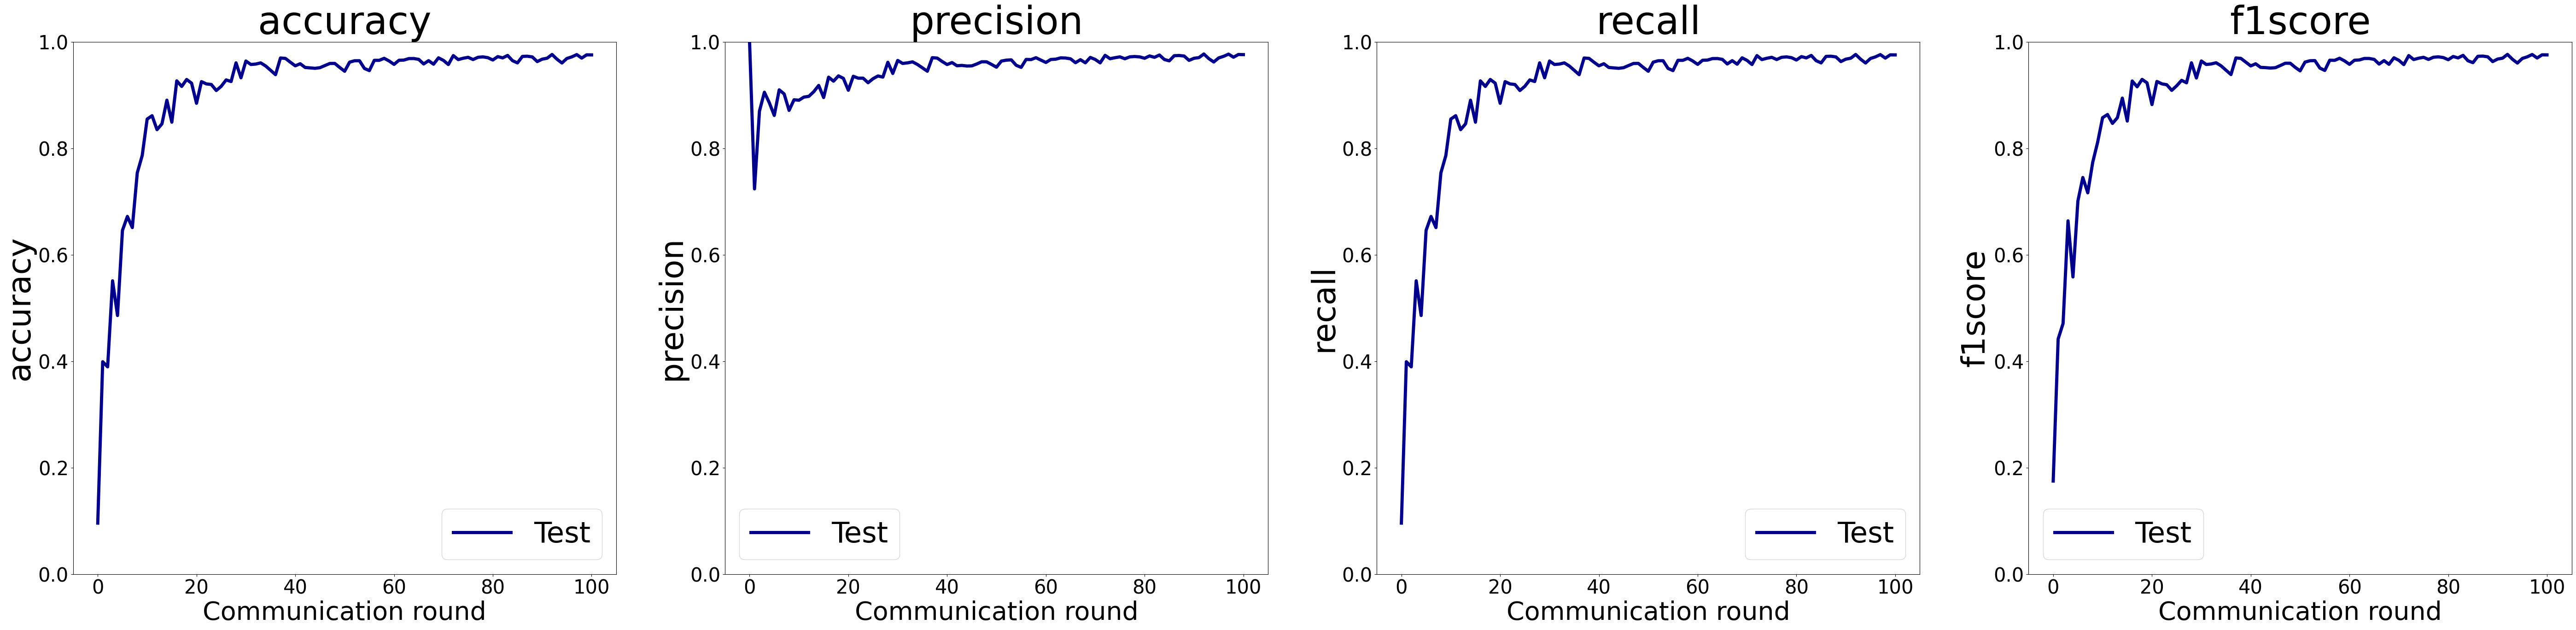

In [8]:
# Define metrics to plot
metrics_show = ["accuracy","precision","recall","f1score"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(70,15))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])